Energy estimation using Random Forest Regression with or w/o using sample weights on events while training.

In [1]:
import glob
import numpy
import sys, os
import tables
from scipy.optimize import curve_fit
import pyunfold

import matplotlib
import matplotlib.backends.backend_pdf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
%matplotlib inline

params = {'legend.fontsize': 18,
          'axes.labelsize': 22,
          'axes.titlesize':23,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'figure.figsize':(10, 8),
          'axes.grid':True}
plt.rcParams.update(params)


In [2]:
print "All required Functions"

def H4a(cycle, E):
    # https://arxiv.org/pdf/1111.6675v2.pdf
    # Tom's Model, H4a,    dN/dln(E) = EdN/dE [m^(-2) s^(-1) sr^(-1)]
    # Used to plot Peter-Cycle
    # H4a assumes the third population is all proton from extra-galactic sources.
    Proton_model = numpy.array([7860*(pow(E,-1.66))*numpy.exp(-E/(1.*4e6)),  
                               20  *(pow(E,-1.40))*numpy.exp(-E/(1.*30e6)),
                               200 *(pow(E,-1.60))*numpy.exp(-E/(1.*60e9))])
                   
    Helium_model = numpy.array([3550*(pow(E,-1.58))*numpy.exp(-E/(2.*4e6)),
                               20  *(pow(E,-1.40))*numpy.exp(-E/(2.*30e6))])
                   
    Oxygen_model = numpy.array([2200*(pow(E,-1.63))*numpy.exp(-E/(8.*4e6)),
                               13.4*(pow(E,-1.40))*numpy.exp(-E/(8.*30e6))])
                               
    Silicon_model= numpy.array([1430*(pow(E,-1.67))*numpy.exp(-E/(14.*4e6)),
                               13.4*(pow(E,-1.40))*numpy.exp(-E/(14.*30e6))])
                   
    Iron_model   = numpy.array([2120*(pow(E,-1.63))*numpy.exp(-E/(26.*4e6)),
                               13.4*(pow(E,-1.40))*numpy.exp(-E/(26.*30e6))])
                   
    if cycle=='1st':
        return Proton_model[0] + Helium_model[0] + Oxygen_model[0] + Silicon_model[0] + Iron_model[0]
    elif cycle=='2nd':
        return Proton_model[1] + Helium_model[1] + Oxygen_model[1] + Silicon_model[1] + Iron_model[1]
    elif cycle=='3rd':
        return Proton_model[2]
    elif cycle=='all':
        return Proton_model[0] + Helium_model[0] + Oxygen_model[0] + Silicon_model[0] + Iron_model[0] + \
               Proton_model[1] + Helium_model[1] + Oxygen_model[1] + Silicon_model[1] + Iron_model[1] + \
               Proton_model[2]

def H3a(cycle, E):
    # https://arxiv.org/pdf/1111.6675v2.pdf
    # Tom's Model, H4a,    dN/dln(E) = EdN/dE [m^(-2) s^(-1) sr^(-1)]
    # Used to plot Peter-Cycle
    # The model H3a with a mixed extra-galactic population (Fig. 2)
    # has all iron at the highest energy and would represent a
    # scenario in which the cutoff is not an effect of energy loss
    # in propagation over cosmic distances through the CMB but is
    # instead just the extra-galactic accelerators reaching their
    # highest energy.
    Proton_model = numpy.array([7860*(pow(E,-1.66))*numpy.exp(-E/(1.*4e6)),  
                               20  *(pow(E,-1.40))*numpy.exp(-E/(1.*30e6)),
                               1.7 *(pow(E,-1.40))*numpy.exp(-E/(1.*2e9))])
                   
    Helium_model = numpy.array([3550*(pow(E,-1.58))*numpy.exp(-E/(2.*4e6)),
                               20  *(pow(E,-1.40))*numpy.exp(-E/(2.*30e6)),
                               1.7 *(pow(E,-1.40))*numpy.exp(-E/(2.*2e9))])
                   
    Oxygen_model = numpy.array([2200*(pow(E,-1.63))*numpy.exp(-E/(8.*4e6)),
                               13.4*(pow(E,-1.40))*numpy.exp(-E/(8.*30e6)),
                               1.14*(pow(E,-1.40))*numpy.exp(-E/(8.*2e9))])
                               
    Silicon_model= numpy.array([1430*(pow(E,-1.67))*numpy.exp(-E/(14.*4e6)),
                               13.4*(pow(E,-1.40))*numpy.exp(-E/(14.*30e6)),
                               1.14*(pow(E,-1.40))*numpy.exp(-E/(14.*2e9))])
                   
    Iron_model   = numpy.array([2120*(pow(E,-1.63))*numpy.exp(-E/(26.*4e6)),
                               13.4*(pow(E,-1.40))*numpy.exp(-E/(26.*30e6)),
                               1.14*(pow(E,-1.40))*numpy.exp(-E/(26.*2e9))])
                   
    if cycle=='1st':
        return Proton_model[0] + Helium_model[0] + Oxygen_model[0] + Silicon_model[0] + Iron_model[0]
    elif cycle=='2nd':
        return Proton_model[1] + Helium_model[1] + Oxygen_model[1] + Silicon_model[1] + Iron_model[1]
    elif cycle=='3rd':
        return Proton_model[2] + Helium_model[2] + Oxygen_model[2] + Silicon_model[2] + Iron_model[2]
    elif cycle=='all':
        return Proton_model[0] + Helium_model[0] + Oxygen_model[0] + Silicon_model[0] + Iron_model[0] + \
               Proton_model[1] + Helium_model[1] + Oxygen_model[1] + Silicon_model[1] + Iron_model[1] + \
               Proton_model[2] + Helium_model[2] + Oxygen_model[2] + Silicon_model[2] + Iron_model[2]
            
# Mean of energy bin
def mean_bin_center(E, g):
    Ef = E[1:]
    Eo = E[:-1]
    ka = 1-g
    Emean = (0.5*(Eo**ka + Ef**ka))**(1./ka)
    return Emean

def scale_factor_func(E, scale):
    return E**(scale-1)

def systematics_quadrature(sys_list):
    total_systematics = 0
    for sys in sys_list:
        sys = numpy.array(sys)
        total_systematics += sys*sys
    return numpy.sqrt(total_systematics)
    
def errorXbyY(X, Y, errX, errY):
    import numpy
    error = numpy.sqrt((errX/Y)**2 + (X*errY/(Y**2))**2)
    return error

def gaussian(x, a, b, c):
    # Gaussian function to be used for getting mean and sigma of energy distribution.
    c = abs(c)
    return a*numpy.exp(-(x-b)**2/(2*c*c))

def circular_containment(core_x, core_y, cont_radius=45.):
    '''
    tank_positions = {26: {'A': [13.460000038146973, -129.35499572753906],
                           'B': [20.950000762939453, -135.9149932861328]},                       
                      36: {'A': [37.435001373291016, -57.36000061035156],                   
                           'B': [29.18000030517578, -52.80500030517578]},                        
                      46: {'A': [71.3499984741211, 66.82499694824219],                      
                           'B': [67.07500076293945, 75.39500045776367]},                         
                      79: {'A': [18.09999942779541, -94.63000106811523],                    
                           'B': [10.880000114440918, -87.69499969482422]},                       
                      80: {'A': [76.42499923706055, -42.47999954223633],                    
                           'B': [85.64500045776367, -46.0]},                                     
                      81: {'A': [77.40999984741211, 37.6150016784668],                      
                           'B': [87.19000244140625, 39.84000015258789]}                          
                  }
    '''
    x = numpy.array([13.460000038146973, 20.950000762939453, 37.435001373291016, 29.18000030517578, 71.3499984741211, 
                     67.07500076293945,  18.09999942779541,  10.880000114440918, 76.42499923706055, 85.64500045776367, 
                     77.40999984741211, 87.19000244140625])
    y = numpy.array([-129.35499572753906, -135.9149932861328, -57.36000061035156, -52.80500030517578, 66.82499694824219, 
                     75.39500045776367,   -94.63000106811523, -87.69499969482422, -42.47999954223633, -46.0, 
                     37.6150016784668, 39.84000015258789])

    boolean = numpy.array(len(core_x)*[False])
    for i in range(len(x)):
        x1 = x[i] - core_x
        y1 = y[i] - core_y
        distance = numpy.sqrt(x1*x1 + y1*y1)
        boolean = numpy.logical_or(boolean, (distance<=cont_radius))

    return boolean

"""
Dynamic way of calculating Ngenerated.
Covers: what composition model?
        what particle type? [H only, He only, O only, Fe only or all of them at once.]

"""
def weighted_Ngenerated(loge_bins=numpy.linspace(4.0,7.4,18), 
                        particle='all', 
                        composition_model='h4a',
                        isqgsjet=False
                       ):
    # Calculate number of events generated that is used to do detector simulation.
    # This is required to calculate efficiency.
    import tables
    sys.path.append('/Users/rameshkoirala/Documents/Paper')
    from weighting import weighting_H4a#, weighting_GST, weighting_PolygonatoTG, weighting_GSF


    mcdirpath = '/Users/rameshkoirala/Documents/LowEnergy/MCPrimaryInfo/'
    

    weighting_func = weighting_H4a
    which_flux     = 'median'

    if particle=='all':
        particle_list = ['proton', 'helium', 'oxygen', 'iron']
        do            = 'one_particle_flux'
    else:
        particle_list = [particle]
        do            = 'all_particle_flux'

    wtNgen   = 0.
    Ngen_err = 0.
    num_evt  = 0.
    print 'Particle: ', particle_list
    for par in particle_list:
        if isqgsjet:
            filename = mcdirpath+'detector_sim_mcprimary_qgsjet_'+par+'.h5'
        else:
            filename = mcdirpath+'detector_sim_mcprimary_'+par+'.h5'
            
        hf       = tables.open_file(filename)
        energy   = hf.root.MCPrimary.cols.energy[:]
        if len(particle_list)==1: # one particle assumption
            node_name = 'weight_1ParAssumption_'+par+'_'+composition_model+'Orig'
        if len(particle_list)==4: # 4 groups of particle.
            node_name = 'weight_'+par+'_'+composition_model+'Orig'
        if node_name in hf.root:
            wt_n      = hf.get_node('/', node_name)
            wt        = wt_n.read()
        else:
            hf.close()
            wt        = weighting_func(energy, particle=par, do=do, which_flux=which_flux, isqgsjet=isqgsjet)
            hf        = tables.open_file(filename, 'a')
            hf.create_array('/', node_name, wt)
                
        czenith   = numpy.cos(hf.root.MCPrimary.cols.zenith[:])
        mask      = (czenith>=cos2)*(czenith<=cos1)
        hf.close()
        Ngen_     = numpy.histogram(energy[mask], bins=10**loge_bins)[0]
        wtNgen_   = numpy.histogram(energy[mask], bins=10**loge_bins, weights=wt[mask])[0]
        Ngen_err_ = numpy.histogram(energy[mask], bins=10**loge_bins, weights=(wt[mask])*(wt[mask]))[0]
        wtNgen   += wtNgen_
        Ngen_err += Ngen_err_
        num_evt  += Ngen_
        Ngen_err[numpy.where(numpy.isinf(Ngen_err))] = 0
        
    return wtNgen, Ngen_err, num_evt

def sigmoid_func(x, p0, p1, p2):
    return p0/(1 + numpy.exp(-p1*(x-p2))) # bhaktiyar sigmoid

def efficiency(logEnergy, Weight, 
               loge_bins, 
               particle='all', 
               composition_model='h4a'):
    """
    Efficiency for input logenergy after all quality cuts. Energy can be both True or Reconstructed.
    """
    wtNgenerated, Ngen_err, num_evt_gen = weighted_Ngenerated(loge_bins=loge_bins,
                                                particle=particle, 
                                                composition_model=composition_model)
    wtNtrue   = numpy.histogram(logEnergy, bins=loge_bins, weights=Weight)[0]
    Ntrue_err = numpy.sqrt(numpy.histogram(logEnergy, bins=loge_bins, 
                                           weights=(Weight*Weight))[0])
    error_eff = numpy.sqrt((Ntrue_err/wtNgenerated)**2 + (wtNtrue*Ngen_err/(wtNgenerated**2))**2)
    eff       = wtNtrue/wtNgenerated
    
    print (numpy.histogram(logEnergy, bins=loge_bins)[0])/num_evt_gen
    
    return eff, error_eff

def effective_area(eff, loge_bins, fitted=False):
    # This works both for effective area and its error.
    # Input: Efficiency, or Error on efficiency.
    
    truncated_bins = loge_bins[:-1] 
    if isinstance(eff, (numpy.ndarray, list)):
        pass
    elif isinstance(eff, (float, int)):
        eff = numpy.ones(len(truncated_bins)) * eff 

    RSim45 = 200.
    RSim56 = 400.
    RSim67 = 600.
    RSim78 = 800.

    AreaSim45 = numpy.pi*RSim45*RSim45
    AreaSim56 = numpy.pi*RSim56*RSim56
    AreaSim67 = numpy.pi*RSim67*RSim67
    AreaSim78 = numpy.pi*RSim78*RSim78

    mask45 = (truncated_bins>=4)*(truncated_bins<5)
    mask56 = (truncated_bins>=5)*(truncated_bins<6)
    mask67 = (truncated_bins>=6)*(truncated_bins<7)
    mask78 = (truncated_bins>=7)*(truncated_bins<8)

    Aeff         = numpy.zeros(len(eff))
    Aeff[mask45] = AreaSim45*(eff[mask45])
    Aeff[mask56] = AreaSim56*(eff[mask56])
    Aeff[mask67] = AreaSim67*(eff[mask67])
    Aeff[mask78] = AreaSim78*(eff[mask78])
    
    if fitted:
        mid_logE = 0.5*(loge_bins[1:]+loge_bins[:-1])
        effx = numpy.linspace(min(mid_logE),max(mid_logE),501)
        init = [max(Aeff), 5., 5.]
        mask = (mid_logE>=5.4)*(mid_logE<=7.0)
        popt, pcov = curve_fit(sigmoid_func, mid_logE[mask], Aeff[mask], 
                                 p0=init, sigma=ErrAeff[mask])
        Aeff               = sigmoid_func(mid_logE, *popt)
        return Aeff, popt, pcov

    else:
        return Aeff

def cr_flux(logene_spectrum, 
        loge_bins=numpy.linspace(4,7.4,18), 
        Aeff=1.,
        cos1=1, cos2=0.9,
        duration=1.
        ):
    lnE      = loge_bins/numpy.log10(numpy.exp(1))
    dlnE     = numpy.diff(lnE)
    exposure = Aeff*numpy.pi*((cos1**2) - (cos2**2))*duration
    flux     = logene_spectrum/(dlnE*exposure)
    
    return flux


All required Functions


In [3]:
print 'Analysis class'
class Analysis(object):

    def __init__(self):
        self.angle_bins    = numpy.linspace(0,60,121)
        self.beta_bins     = numpy.linspace(-3., 10., 66)
        self.chi2_bins     = numpy.linspace(0, 50, 501)
        self.core_bins     = numpy.linspace(1,80,80)
        self.cos_bins      = numpy.linspace(0.8,1., 5)
        self.cosz_bins     = numpy.linspace(0.4, 1, 81)
        self.coreres_bins  = numpy.linspace(0,100,101)
        self.charge_bins   = numpy.logspace(-1, 4, 51)
        self.distance_bins = numpy.linspace(0, 600, 601)
        self.energy_dir    = numpy.linspace(4.0, 7, 31) #linspace 
        self.ene_bins      = numpy.logspace(4.0,7.6,19)   #logspace
        self.eneres_bins   = numpy.linspace(-2,2,41)
        self.position_bins = numpy.linspace(-600, 600, 241)
        self.ndf_bins      = numpy.linspace(0, 162, 163)
        self.qtotal_bins   = numpy.logspace(-1, 5, 61)
        self.s60_bins      = numpy.logspace(-1, 4, 51)
        self.station_bins  = numpy.linspace(0, 90, 91)
        self.tank_bins     = numpy.linspace(0, 162, 163)   # total num of tanks = 162           
        
        self.particle_dict_h = {'proton': '10410',
                                'helium': '11663',
                                'oxygen': '12605',
                                'iron'  : '10889'}
        self.particle_dict_l = {'proton': '9508',
                                'helium': '7362',
                                'oxygen': '7364',
                                'iron'  : '9614'}

    def angle_betn_two_vectors(self, true_zenith, true_azimuth, reco_zenith, reco_azimuth):
        # Find unit vector with given zenith and azimuth.                             
        truex = numpy.sin(true_zenith)*numpy.cos(true_azimuth)
        truey = numpy.sin(true_zenith)*numpy.sin(true_azimuth)
        truez = numpy.cos(true_zenith)
        recox = numpy.sin(reco_zenith)*numpy.cos(reco_azimuth)
        recoy = numpy.sin(reco_zenith)*numpy.sin(reco_azimuth)
        recoz = numpy.cos(reco_zenith)
        V1    = numpy.array([truex, truey, truez])
        V2    = numpy.array([recox, recoy, recoz])
        magV1 = numpy.sqrt((V1[0])**2 + (V1[1])**2 + (V1[2])**2)
        magV2 = numpy.sqrt((V2[0])**2 + (V2[1])**2 + (V2[2])**2)
        cos_theta = ((V1[0])*(V2[0]) + (V1[1])*(V2[1]) + (V1[2])*(V2[2]))/(magV1 * magV2)
        angle = numpy.rad2deg(numpy.arccos(cos_theta))

        return angle

    def circular_containment(self, core_x, core_y, cont_radius=45.):
        '''
        tank_positions = {26: {'A': [13.460000038146973, -129.35499572753906],
                               'B': [20.950000762939453, -135.9149932861328]},                       
                          36: {'A': [37.435001373291016, -57.36000061035156],                   
                               'B': [29.18000030517578, -52.80500030517578]},                        
                          46: {'A': [71.3499984741211, 66.82499694824219],                      
                               'B': [67.07500076293945, 75.39500045776367]},                         
                          79: {'A': [18.09999942779541, -94.63000106811523],                    
                               'B': [10.880000114440918, -87.69499969482422]},                       
                          80: {'A': [76.42499923706055, -42.47999954223633],                    
                               'B': [85.64500045776367, -46.0]},                                     
                          81: {'A': [77.40999984741211, 37.6150016784668],                      
                               'B': [87.19000244140625, 39.84000015258789]}                          
                      }
        '''
        x = numpy.array([13.460000038146973, 20.950000762939453, 37.435001373291016, 29.18000030517578, 71.3499984741211, 
                         67.07500076293945,  18.09999942779541,  10.880000114440918, 76.42499923706055, 85.64500045776367, 
                         77.40999984741211, 87.19000244140625])
        y = numpy.array([-129.35499572753906, -135.9149932861328, -57.36000061035156, -52.80500030517578, 66.82499694824219, 
                         75.39500045776367,   -94.63000106811523, -87.69499969482422, -42.47999954223633, -46.0, 
                         37.6150016784668, 39.84000015258789])

        boolean = numpy.array(len(core_x)*[False])
        for i in range(len(x)):
            x1 = x[i] - core_x
            y1 = y[i] - core_y
            distance = numpy.sqrt(x1*x1 + y1*y1)
            boolean = numpy.logical_or(boolean, (distance<=cont_radius))
            
        return boolean

    def directional_histogram(self, true_zenith, true_azimuth, reco_zenith, reco_azimuth, weights=None):
        # Find unit vector with given zenith and azimuth.    
        truex = numpy.sin(true_zenith)*numpy.cos(true_azimuth)
        truey = numpy.sin(true_zenith)*numpy.sin(true_azimuth)
        truez = numpy.cos(true_zenith)
        recox = numpy.sin(reco_zenith)*numpy.cos(reco_azimuth)
        recoy = numpy.sin(reco_zenith)*numpy.sin(reco_azimuth)
        recoz = numpy.cos(reco_zenith)
        true_vec = numpy.array([truex, truey, truez])
        reco_vec = numpy.array([recox, recoy, recoz])
        angle = self.angle_betn_two_vectors(true_vec, reco_vec) # angle in deg
        angley, anglex = numpy.histogram(angle, bins=self.angle_bins, weights=weights) 
        # angle bins = 60 [0,1,2..61]

        return angley, anglex

    def polygonato_all(self):
        E          = self.ene_bins[:-1] + numpy.diff(self.ene_bins)/2.

        gamma = numpy.array([[1.71, 1.64, 1.67, 1.70, 1.55],
                             [1.40, 1.40, 1.40, 1.40, 1.40],
                             [1.40, 1.40, 1.40, 1.40, 1.40]])
        a     = numpy.array([[11800, 4750, 3860, 3120, 1080],
                             [11.8, 11.8, 7.88, 7.88, 7.88],
                             [1.7, 1.7, 1.14, 1.14, 1.14]])
        Z     = numpy.array([1, 2, 8, 14, 26])
        Rcut  = [4.49e6, 30e6, 2e9] #GV                                                                                                                                                
        flux_population = numpy.zeros(len(E))
        for par_indx in range(5):
            for j in range(3):
                flux = a[j][par_indx]*E**(-gamma[j][par_indx])*numpy.exp(-E/(Z[par_indx]*Rcut[j]))
                flux_population += flux

        return flux_population
    
analysis = Analysis()

Analysis class


In [4]:
print "Steering File"
print "Select what option to pass."

# Order what to do!!!!!
name               = '_paper'#'_paper'#'_slcQcut'#'_nsta',  '_23oct2018', '_10dec2018'
particle           = 'all'    # 'all'
composition_model  = 'h4a'    # 'h4a', 'gst', 'poly', 'gsfL', 'gsfM', 'gsfH'

# Values
cos1               = 1.0  # upper bound: 1.0
cos2               = 0.9  # Lower bound: 0.9
qsum2_frac         = 0.9  # Qsum2<=qsum2_frac*Qtotal

# Boolean
savefig            = False
savehdf            = False
plot_hawc          = False
plot_h4a           = False
plot_unfolding     = False
scale_unfolding    = False
which_scalingE_list= ['scale_midlogE', 'scale_meanEtrue', 'scale_fitPowerLaw']
which_prior_list   = ['MCobs', 'NEobs', 'uniform', 'jeffreys']
which_scaling      = which_scalingE_list[1]
which_prior        = which_prior_list[3]

# PPlus, He4Nucleus, O16Nucleus , Fe56Nucleus. Used to get fraction of flux contributed by this particular particle.
pdgcode_dict       = {
                        'proton':2212,
                        'helium':1000020040,
                        'oxygen':1000080160,
                        'iron'  :1000260560
                     }
if particle!='all':
    pdgcode = pdgcode_dict[particle]

# Link to a directory or a file
savedir     = '/Users/rameshkoirala/Documents/Paper/'
rfr_savedir = '/Users/rameshkoirala/Documents/Paper/Plot/'
datadir     = "/Users/rameshkoirala/Documents/Paper/"
datafile    = "analysis_simulation_HLCCoreSeed_slcQcut_fracradius_final.h5"


Steering File
Select what option to pass.


In [5]:
print 'all bins'
loge_bins     = numpy.linspace(4.0,7.4,18) #18, 35
mid_logE         = 0.5*(loge_bins[1:]+loge_bins[:-1])

model_bin = numpy.linspace(4,7.4,200) # to plot h4a model

# Used later while calculating/plotting flux.
lnE      = loge_bins/numpy.log10(numpy.exp(1))
dlnE     = numpy.diff(lnE)
lenbins  = len(mid_logE)

all bins


In [6]:
if False:
    hf         = tables.open_file(datadir+datafile)
    Tenergy    = hf.root.Energy[:]
    logPenergy = hf.root.PredictedLogEnergy_h4a[:]
    FiltCondt  = hf.root.FiltCondt[:]
    LoudSta    = hf.root.LoudSta[:]
    Qtotalhlc  = hf.root.Qtotalhlc[:]
    Nsta       = hf.root.Nsta[:]
    PredictedX = hf.root.PredictedX[:]
    PredictedY = hf.root.PredictedY[:]
    Pzenith    = hf.root.PredictedZen[:]
    Pulses     = hf.root.Pulses[:]
    Qsum2      = numpy.sum(Pulses[:,:2], axis=1)
    TankX      = hf.root.TankX[:]
    TankY      = hf.root.TankY[:]
    Weight     = hf.root.WeightH4a[:]
    PDG        = hf.root.pdg_encoding[:]
    hf.close()

    TankX[TankX==0] = 1.e4
    TankY[TankY==0] = 1.e4
    #----------------------------
    # Calculated 
    Radius     = numpy.sqrt((TankX - PredictedX[:,numpy.newaxis])**2 + (TankY - PredictedY[:,numpy.newaxis])**2)
    Radius[numpy.where((TankX==0)*(TankY==0))] = 0. #If nothing was hit, tank positions was set to (0,0) to fill array. 
    Radius     = -numpy.sort(-Radius, axis=1)       # Distance of tank-core in descending order per event.
    fracRadius = Radius/60.
    maxRadius  = numpy.max(Radius, axis=1)
    TankDensity= Nsta/(numpy.pi*maxRadius*maxRadius)

    # Quality Cuts so that you train on nicely behaving events.
    qualmask  = FiltCondt==1
    qualmask *= (LoudSta==1)
    qualmask *= (Qsum2<=qsum2_frac*Qtotalhlc) # Make sure not all charge is stored in 1 station.
    qualmask *= (numpy.cos(Pzenith)>=0.8)*(numpy.cos(Pzenith)<=1.0)

    Tenergy    = Tenergy[qualmask]
    Pzenith    = Pzenith[qualmask]
    Qtotalhlc  = Qtotalhlc[qualmask]
    Qsum2      = Qsum2[qualmask]
    Pulses     = Pulses[qualmask]
    fracRadius = fracRadius[qualmask]
    PredictedX = PredictedX[qualmask]
    PredictedY = PredictedY[qualmask]
    Nsta       = Nsta[qualmask]
    Weight     = Weight[qualmask]

    # Get weight for Qhit
    def func(ar):
        ka = list(ar)
        return numpy.array(35*ka)

    wtforQhit = numpy.apply_along_axis(func, 1, Weight[:,numpy.newaxis])
    enforQhit = numpy.apply_along_axis(func, 1, Tenergy[:,numpy.newaxis])
    print wtforQhit.shape, enforQhit.shape


    plt.figure()
    abc = plt.hist2d(numpy.log10(Tenergy), logPenergy, weights=Weight, 
                     bins=[100,100], cmap='Spectral_r', norm=LogNorm())
    plt.plot([4,7.5], [4,7.5], 'k--', lw=2, alpha=0.5)
    plt.xlabel('logEtrue')
    plt.ylabel('logEreco')
    plt.colorbar()
    plt.xlim(4,7.5)
    plt.ylim(4,7.5)

    plt.figure()
    flatr = fracRadius.flatten()
    abc = plt.hist(numpy.log10(flatr[flatr>0]), bins=200)
    #plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0,12)
    plt.xlabel('Radius/60')

    plt.figure()
    flatpluse = Pulses.flatten()
    abc = plt.hist(numpy.log10(flatpluse[flatpluse>0]), bins=200)
    #plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0,12)
    plt.xlabel('logQhit')

    plt.figure()
    abc = plt.hist(numpy.log10(Qtotalhlc), bins=100)
    plt.yscale('log')
    #plt.xlim(0,12)
    plt.xlabel('logQtot')

    plt.figure()
    flatene = enforQhit.flatten()
    flatwt  = wtforQhit.flatten()
    abc = plt.hist2d(numpy.log10(flatene[flatpluse>0]), numpy.log10(flatpluse[flatpluse>0]), 
                     weights=flatwt[flatpluse>0], bins=[100,100])
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim(0,12)
    plt.xlabel('logE')
    plt.ylabel('logQhit')
    
    plt.figure()
    abc = plt.hist2d(numpy.log10(Tenergy), numpy.log10(Qtotalhlc), weights=Weight, 
                     bins=[100,100], cmap='Spectral_r', norm=LogNorm())
    plt.xlabel('logEtrue')
    plt.ylabel('logQtot')
    plt.colorbar()

    plt.figure()
    abc = plt.hist2d(numpy.log10(Tenergy), numpy.log10(Qsum2), weights=Weight, 
                     bins=[100,100], cmap='Spectral_r', norm=LogNorm())
    plt.xlabel('logEtrue')
    plt.ylabel('logQsum2')
    plt.colorbar()


In [7]:
print '=====Check that 200, 400, 600, 800 m choice for re-sampling radius is a good choice======'

if False:
    hf    = tables.open_file(datadir+datafile)
    logTE = numpy.log10(hf.root.Energy[:])
    WT    = hf.root.WeightH4a[:]
    FC    = hf.root.FiltCondt[:]
    TX    = hf.root.Tcorex[:]
    TY    = hf.root.Tcorey[:]
    hf.close()

    lim = 200
    plt.figure(figsize=(9, 7))
    mask = (logTE>=4)*(logTE<5)*(FC==1)
    abc = plt.hist2d(TX[mask], TY[mask], bins=[50,50], weights=WT[mask], norm=LogNorm())
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.xticks(rotation='30')
    plt.title('Re-sampling Radius Check [log(E/GeV)=4-5]', fontsize=18)
    plt.colorbar(label='Rate[Hz]')
    plt.savefig('../resampling_radius_check_200m_logE4_5.png', bbox_inches='tight')

    lim = 400
    plt.figure(figsize=(9, 7))
    mask = (logTE>=5)*(logTE<6)*(FC==1)
    abc = plt.hist2d(TX[mask], TY[mask], bins=[50,50], weights=WT[mask], norm=LogNorm())
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.xticks(rotation='30')
    plt.title('Re-sampling Radius Check [log(E/GeV)=5-6]', fontsize=18)
    plt.colorbar(label='Rate[Hz]')
    plt.savefig('../resampling_radius_check_400m_logE5_6.png', bbox_inches='tight')


    lim = 600
    plt.figure(figsize=(9, 7))
    mask = (logTE>=6)*(logTE<7)*(FC==1)
    abc = plt.hist2d(TX[mask], TY[mask], bins=[50,50], weights=WT[mask], norm=LogNorm())
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.xticks(rotation='30')
    plt.title('Re-sampling Radius Check [log(E/GeV)=6-7]', fontsize=18)
    plt.colorbar(label='Rate[Hz]')
    plt.savefig('../resampling_radius_check_600m_logE6_7.png', bbox_inches='tight')


    lim = 800
    plt.figure(figsize=(9, 7))
    mask = (logTE>=7)*(logTE<8)*(FC==1)
    abc = plt.hist2d(TX[mask], TY[mask], bins=[50,50], weights=WT[mask], norm=LogNorm())
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.xticks(rotation='30')
    plt.title('Re-sampling Radius Check [log(E/GeV)=7-7.4]', fontsize=17)
    plt.colorbar(label='Rate[Hz]')
    plt.savefig('../resampling_radius_check_800m_logE7_7.4.png', bbox_inches='tight')



=====Check that 200, 400, 600, 800 m choice for re-sampling radius is a good choice======


===============MC Data=============


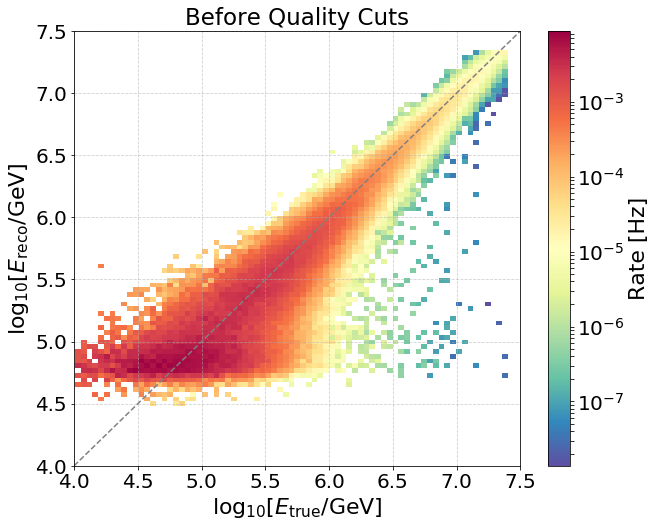

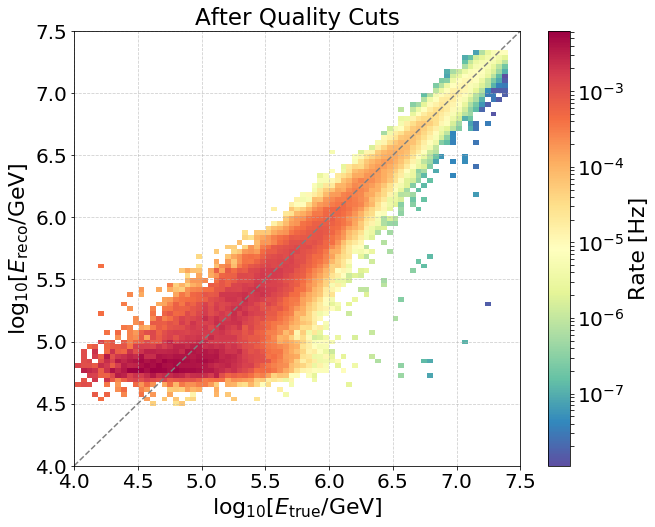

In [8]:
print '===============MC Data============='
hf         = tables.open_file(datadir+datafile)
logTenergy = numpy.log10(hf.root.Energy[:])
logPenergy = hf.root.PredictedLogEnergy_h4aOrig[:]
if particle=='all':
    Weight     = hf.root.WeightH4aOrig[:]
else:
    Weight = hf.root.Weight1ParticleAssumptionH4aOrig[:]
FiltCondt  = hf.root.FiltCondt[:]
Pulses     = hf.root.Pulses[:]
LoudSta    = hf.root.LoudSta[:]
Nsta       = hf.root.Nsta[:]
PlaneZenith= hf.root.PlaneZenith[:]
PlaneAzimuth= hf.root.PlaneAzimuth[:]
Qhillas    = hf.root.Qhillas[:]
Qmax       = Pulses[:,0]
Qsum2      = numpy.sum(Pulses[:,:2], axis=1)
Qtotalhlc  = hf.root.Qtotalhlc[:]
Tcorex     = hf.root.Tcorex[:]
Tcorey     = hf.root.Tcorey[:]
Pcorex     = hf.root.PredictedX[:]
Pcorey     = hf.root.PredictedY[:]
Tzenith    = hf.root.Tzenith[:]
Pzenith    = hf.root.PredictedZen[:]
maskene    = hf.root.maskTrainingEnergy_h4aOrig[:]
PDG        = hf.root.pdg_encoding[:]
hf.close()


# maskene includes:
#qualmask  = FiltCondt==1
#qualmask *= (LoudSta==1)
#qualmask *= (Qsum2<=qsum2_frac*Qtotalhlc) # Make sure not all charge is stored in 1 station.
#qualmask *= (numpy.cos(Pzenith)>=0.8)*(numpy.cos(Pzenith)<=1.0)

# Apply mask to make it like energy.
logTenergy= logTenergy[maskene]
Qtotalhlc = Qtotalhlc[maskene]
Nsta      = Nsta[maskene]
PlaneAzimuth      = PlaneAzimuth[maskene]
#Ntanks    = Ntanks[maskene]
Qmax      = Qmax[maskene]
Qsum2     = Qsum2[maskene]
Tcorex    = Tcorex[maskene]
Tcorey    = Tcorey[maskene]
Pcorex    = Pcorex[maskene]
Pcorey    = Pcorey[maskene]
Tzenith   = Tzenith[maskene]
Pzenith   = Pzenith[maskene]
Weight    = Weight[maskene]
PDG       = PDG[maskene]


# Now apply additional quality cuts
qualmask  = (numpy.cos(Pzenith)>=cos2)*(numpy.cos(Pzenith)<=cos1)
qualmask *= (Nsta<=42)*(Qtotalhlc<=10**3.8)*(Qtotalhlc>=10**-0.2) #42, 3.8, -0.2
qualmask *= Qmax<=0.75*Qtotalhlc #0.75
qualmask *= Qsum2<=0.9*Qtotalhlc #0.9
#qualmask *= circular_containment(Pcorex, Pcorey, cont_radius=60.)
if particle!='all':
    print 'working with particle: ', particle, pdgcode
    qualmask *= PDG==pdgcode

plt.figure(figsize=(10,8))
abc = plt.hist2d(logTenergy, logPenergy, weights=Weight, bins=[75,75], 
                 norm=LogNorm(), cmap='Spectral_r')
plt.xlabel(r'log$_{10}$[$E_{\rm true}$/GeV]')
plt.ylabel(r'log$_{10}$[$E_{\rm reco}$/GeV]')
plt.xlim(4,7.5)
plt.ylim(4,7.5)
plt.grid(linestyle='--', alpha=0.6)
plt.colorbar(label='Rate [Hz]')
plt.title("Before Quality Cuts")
plt.plot([4,7.5], [4,7.5], color='gray', lw=1.5, linestyle='--')
if savefig:
    plt.savefig(rfr_savedir+'ene_scatter_2d_beforequalcuts%s.png'%name, bbox_inches='tight')

# Apply mask to make it ready to calculate resolution.
logTenergy= logTenergy[qualmask]
logPenergy= logPenergy[qualmask]
Qtotalhlc = Qtotalhlc[qualmask]
Nsta      = Nsta[qualmask]
Qmax      = Qmax[qualmask]
Tcorex    = Tcorex[qualmask]
Tcorey    = Tcorey[qualmask]
Pcorex    = Pcorex[qualmask]
Pcorey    = Pcorey[qualmask]
Tzenith   = Tzenith[qualmask]
Pzenith   = Pzenith[qualmask]
Plane_azi = PlaneAzimuth[qualmask]
Weight    = Weight[qualmask]

# ----------------------------------------
plt.figure(figsize=(10,8))
abc = plt.hist2d(logTenergy, logPenergy, weights=Weight, bins=[75,75], 
                 norm=LogNorm(), cmap='Spectral_r')
plt.xlabel(r'log$_{10}$[$E_{\rm true}$/GeV]')
plt.ylabel(r'log$_{10}$[$E_{\rm reco}$/GeV]')
plt.xlim(4,7.5)
plt.ylim(4,7.5)
plt.grid(linestyle='--', alpha=0.6)
plt.colorbar(label='Rate [Hz]')
plt.title("After Quality Cuts")
plt.plot([4,7.5], [4,7.5], color='gray', lw=1.5, linestyle='--')
if savefig:
    plt.savefig(rfr_savedir+'ene_scatter_2d_afterqualcuts%s.png'%name, bbox_inches='tight')

In [9]:
print 'if Ture, plot True Vs Reco energy, and energy Bias'
if False:
    plt.figure()
    abc = plt.hist2d(logTenergy, logPenergy, weights=Weight, 
                     bins=[100,100], norm=LogNorm())
    plt.xlabel('logEtrue')
    plt.ylabel('logEreco')
    plt.colorbar()
    plt.plot([4.5,7.5], [4.5,7.5], 'k--', lw=2, alpha=0.5)
    
    # ================ Bias ==============
    eneres_bins = numpy.linspace(-2,2,21)
    mid_eneres_bins = 0.5*(eneres_bins[1:]+eneres_bins[:-1])
    resoemin = 4.4
    resoemax = 7.0    
    eneres   = numpy.histogram2d(logPenergy, logTenergy-logPenergy,
                                bins=[loge_bins, eneres_bins],
                                weights=Weight)[0]
    ene_array   = numpy.array([])
    mean_array  = numpy.array([])
    sigma_array = numpy.array([])
    for ka, ene in enumerate(mid_logE):
        if ene>=resoemin and ene<=resoemax: # Only these
            eneres_spectrum = eneres[ka]
            mask = (eneres_spectrum>0)
            poptres, covres = curve_fit(gaussian, mid_eneres_bins[mask], eneres_spectrum[mask], 
                      p0=[1.e-5, 0, 0.5], maxfev=1000)
            mean        = poptres[1]
            sigma       = abs(poptres[2]) # only positive value is used in the function.
            ene_array   = numpy.append(ene_array, ene)
            sigma_array = numpy.append(sigma_array, sigma)
            mean_array  = numpy.append(mean_array, mean)

    plt.figure()
    tmpmask = (logPenergy>=5.4)*(logPenergy<7.0)
    abc = plt.hist2d(logPenergy, (logTenergy-logPenergy), bins=[numpy.linspace(5.4,7,9), 50], 
                     weights=Weight, norm=LogNorm())
    plt.plot(ene_array, mean_array, 'k^', label=r'Mean')
    plt.ylim(-1.5,1.5)
    plt.xlabel('log[Ereco/GeV]')
    plt.ylabel(r'Bias [$\Delta$log[E/GeV]]')
    plt.colorbar()
    if savefig:
        plt.savefig(rfr_savedir+'bias_reco_energy.png', bbox_inches='tight')
        
        
    eneres   = numpy.histogram2d(logTenergy, logTenergy-logPenergy,
                                bins=[loge_bins, eneres_bins],
                                weights=Weight)[0]
    ene_array   = numpy.array([])
    mean_array  = numpy.array([])
    sigma_array = numpy.array([])
    for ka, ene in enumerate(mid_logE):
        if ene>=resoemin and ene<=resoemax: # Only these
            eneres_spectrum = eneres[ka]
            mask = (eneres_spectrum>0)
            poptres, covres = curve_fit(gaussian, mid_eneres_bins[mask], eneres_spectrum[mask], 
                      p0=[1.e-5, 0, 0.5], maxfev=1000)
            mean        = poptres[1]
            sigma       = abs(poptres[2]) # only positive value is used in the function.
            ene_array   = numpy.append(ene_array, ene)
            sigma_array = numpy.append(sigma_array, sigma)
            mean_array  = numpy.append(mean_array, mean)

    plt.figure()
    abc = plt.hist2d(logTenergy, (logTenergy-logPenergy), bins=[numpy.linspace(5.4,7,9), 50], 
                     weights=Weight, norm=LogNorm())
    plt.plot(ene_array, mean_array, 'k^', label=r'Mean')
    plt.ylim(-1.5,1.5)
    plt.xlabel('log[Etrue/GeV]')
    plt.ylabel(r'Bias [$\Delta$log[E/GeV]]')
    plt.colorbar()
    if savefig:
        plt.savefig(rfr_savedir+'bias_true_energy.png', bbox_inches='tight')


if Ture, plot True Vs Reco energy, and energy Bias


In [10]:
penergy   = logPenergy.copy()
tenergy   = logTenergy.copy()
weight    = Weight.copy()

In [11]:
print 'if True, plot core position'
if False:
    posbins = numpy.linspace(-300,300,61)
    plt.figure(figsize=(8,8))
    abc = plt.hist2d(Tcorex, Pcorex, weights=Weight, bins=[posbins, posbins], 
                     norm=LogNorm(), vmin=1e-8, vmax=1e-1)
    plt.plot([-300,300], [-300,300], linestyle='--', lw=2, color='k', alpha=0.5)
    plt.xlim(-300,300)
    plt.ylim(-300,300)
    plt.xlabel('True X [m]')
    plt.ylabel('Reco X [m]')
    plt.colorbar()
    if savefig:
        plt.savefig(rfr_savedir+'position_scatter_x.png', bbox_inches='tight')

    plt.figure(figsize=(8,8))
    abc = plt.hist2d(Tcorey, Pcorey, weights=Weight, bins=[posbins, posbins], 
                     norm=LogNorm(), vmin=1e-8)
    plt.plot([-300,300], [-300,300], linestyle='--', lw=2, color='k', alpha=0.5)
    plt.xlim(-300,300)
    plt.ylim(-300,300)
    plt.xlabel('True Y [m]')
    plt.ylabel('Reco Y [m]')
    plt.colorbar()
    if savefig:
        plt.savefig(rfr_savedir+'position_scatter_y.png', bbox_inches='tight')

    plt.figure()
    H = plt.hist2d(Tcorex, Tcorey, weights=weight, bins=40, norm=LogNorm(), cmap='Spectral_r')
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('Core Position after Quality Cuts [True]', fontsize=18)
    plt.colorbar(label='a.u')
    plt.xlim(-200,300)
    plt.ylim(-300,300)
    #if savefig:
    if True:
        plt.savefig(rfr_savedir+'position_scatter_xy.png', bbox_inches='tight')


if True, plot core position


In [12]:
print '=============All required Data====================='
# ====================== 3yrs spectrum =================================
H4a_E = numpy.array([6.450, 6.525, 6.575, 6.625, 6.675, 6.725, 6.775, 6.825, 6.875, 6.925, 6.975, 7.025,
                     7.075, 7.125, 7.175, 7.225, 7.275, 7.325, 7.375, 7.425, 7.475, 7.525, 7.575, 7.625,
                     7.675, 7.725, 7.775, 7.825, 7.875, 7.925, 7.975, 8.050, 8.150, 8.250, 8.350, 8.450,
                     8.550, 8.650, 8.750, 8.850, 8.950, 9.050
                    ])

# dN/(dlnE dOmega dA dt)                                                                                                                                                        
H4a_Flux = numpy.array([4.874876e-07, 3.561436e-07, 2.881542e-07, 2.322555e-07, 1.858161e-07, 
                        1.479502e-07, 1.171621e-07, 9.287553e-08, 7.305793e-08, 5.719065e-08, 
                        4.479624e-08, 3.483035e-08, 2.720353e-08, 2.139004e-08, 1.678868e-08, 
                        1.325049e-08, 1.053227e-08, 8.369410e-09, 6.706060e-09, 5.352161e-09, 
                        4.268105e-09, 3.454297e-09, 2.792893e-09, 2.256138e-09, 1.776015e-09, 
                        1.401786e-09, 1.157379e-09, 9.151598e-10, 7.561862e-10, 5.815745e-10, 
                        4.670996e-10, 3.291779e-10, 2.072970e-10, 1.243117e-10, 7.042426e-11, 
                        4.514084e-11, 2.294802e-11, 1.415630e-11, 7.593821e-12, 4.311962e-12, 
                        2.221199e-12, 9.199803e-13])
H4a_Flux_err = numpy.array([2.099E-10,2.498E-10, 2.234E-10, 1.995E-10, 1.778E-10,1.581E-10,
                                1.402E-10,1.245E-10, 1.102E-10, 9.725E-11, 8.592E-11,7.563E-11,
                                6.674E-11,5.910E-11, 5.230E-11, 4.640E-11, 4.132E-11,3.681E-11,
                                3.292E-11,2.939E-11, 2.622E-11, 2.359E-11, 2.116E-11,1.904E-11,
                                1.687E-11,1.497E-11, 1.359E-11, 1.208E-11, 1.098E-11,9.633E-12,
                                8.617E-12,5.120E-12, 4.053E-12, 3.137E-12, 2.360E-12,1.889E-12,
                                1.343E-12,1.061E-12, 7.791E-13, 5.867E-13, 4.195E-13,2.774E-13])

Syst_high = numpy.array([3.67606E-08, 2.86443E-08, 2.29773E-08, 1.89148E-08, 1.56349E-08,
                             1.25324E-08, 1.00030E-08, 8.02676E-09, 6.44238E-09, 5.16727E-09,
                             4.08505E-09, 3.23167E-09, 2.51830E-09, 1.89323E-09, 1.56199E-09,
                             1.18808E-09, 9.15250E-10, 7.76948E-10, 5.77767E-10, 4.98760E-10,
                             3.83445E-10, 3.09929E-10, 2.24941E-10, 2.14448E-10, 1.50013E-10,
                             1.37281E-10, 1.00461E-10, 7.26802E-11, 9.11337E-11, 4.44967E-11,
                             4.16217E-11, 3.27000E-11, 2.01334E-11, 1.29110E-11, 6.31818E-12,
                             4.07038E-12, 2.25524E-12, 1.73793E-12, 2.49281E-12, 4.32947E-13,
                             4.57711E-13, 4.79512E-13])
Syst_low = numpy.array([4.25304E-08, 3.25328E-08, 2.76305E-08,
                            2.16275E-08, 1.79527E-08, 1.39663E-08,1.12869E-08, 9.28657E-09,
                             7.07005E-09, 5.84316E-09, 4.29775E-09, 3.57590E-09, 2.67481E-09,
                            2.11350E-09, 1.61419E-09, 1.18820E-09, 1.02943E-09, 8.14132E-10,
                             5.88148E-10, 5.10979E-10, 3.93476E-10, 3.05541E-10, 2.36948E-10,
                            2.04678E-10, 2.00286E-10, 1.29993E-10,8.40936E-11, 9.32723E-11,
                             6.44922E-11, 5.92049E-11, 3.71297E-11, 3.06249E-11, 2.52663E-11,
                             9.83157E-12, 7.25513E-12, 4.36792E-12, 2.82607E-12, 1.25291E-12,
                             1.99597E-12, 5.95644E-13, 3.92410E-13, 2.49633E-13])
H4a_E_bins = numpy.array([ 6.4, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8,
                           6.85, 6.9, 6.95, 7., 7.05, 7.1, 7.15, 7.2, 7.25,
                           7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7,
                           7.75, 7.8, 7.85, 7.9, 7.95, 8., 8.1, 8.2, 8.3, 8.4, 8.5,
                           8.6, 8.7, 8.8, 8.9, 9., 9.1 ])

# =================== HAWC All-particle Spectrum ===========================
Hawc_E_bins = numpy.array([4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  
                           5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7])
Hawc_E      = 0.5*(Hawc_E_bins[1:]+Hawc_E_bins[:-1])

Hawc_Flux   = numpy.array([4.7968e-7, 2.6922e-7, 1.5163e-7, 8.4947e-8, 4.7823e-8, 2.6761e-8, 
                          1.4823e-8, 8.1839e-9, 4.4769e-9, 2.4193e-9, 1.2781e-9, 6.7636e-10, 
                          3.5835e-10, 1.9107e-10, 1.0346e-10, 5.4882e-11, 2.9284e-11])
Herr_factor= numpy.array([1e-7, 1e-7, 1e-7, 1e-8, 1e-8, 1e-8, 1e-8, 1e-9, 1e-9, 1e-9, 1e-9, 
                          1e-10, 1e-10, 1e-10, 1e-10, 1e-11, 1e-11])
Hawc_err   = numpy.array([0.0002, 0.0001, 0.0001, 0.0007, 0.0005, 0.0003, 0.0002, 0.0015, 0.0010, 0.0007, 0.0004,
                          0.0027, 0.0017, 0.0011, 0.0007, 0.0047, 0.0030])*Herr_factor
Hawc_sysmc = numpy.array([0.5901, 0.2323, 0.1189,  0.7137, 0.3896, 0.2536, 0.1305, 0.8041, 0.4488, 0.2504, 0.1349, 
                          0.6441, 0.3331, 0.1644, 0.0892, 0.4659, 0.2402])*Herr_factor
Hawc_sysl  = numpy.array([0.8530, 0.4467, 0.2356, 1.2419, 0.6614, 0.3522, 0.1869, 0.9947, 0.5281, 0.2787, 0.1447, 
                          0.7576, 0.3995, 0.2134, 0.1166, 0.6286, 0.3441])*Herr_factor
Hawc_sysh  = numpy.array([0.4288, 0.2360, 0.1315, 0.7352, 0.4171, 0.2377, 0.1357, 0.7830, 0.4547, 0.2655, 0.1544, 
                          0.9164, 0.5544, 0.3430, 0.2184, 1.3920, 0.9642])*Herr_factor

hl = numpy.sqrt(Hawc_sysmc**2 + Hawc_sysl**2)
hh = numpy.sqrt(Hawc_sysmc**2 + Hawc_sysh**2)

# =================== MC ======================
eff, error_eff  = efficiency(tenergy, weight,
                             loge_bins=loge_bins,
                             particle=particle,
                             composition_model=composition_model
                            )
AeffO           = effective_area(eff, loge_bins) # Aeff before fitting.
ErrAeff         = effective_area(error_eff, loge_bins)
Aeff,popt_eff, pcov_eff   = effective_area(eff, loge_bins, fitted=True)


# ================== DATA =====================
duration = 28548809.85074771 # Base
#duration = 9110808.2695625   # overburden 698.12 g/cm2
'''
duration  :  [ 28548809.85074771]
durationH :  [ 28609806.45698332]
durationL :  [ 28487813.24451206]
'''
# ============= Asterix: /data/icet0/rkoirala/LowEnergy/RandomForest$ python energy_spectrum.py ============
if len(mid_logE)==17 and cos1==1 and cos2==0.9:
    # ===== 08 Jan 2017 - 28 April 2017 (overburden 698.12 g/cm2) ====
    #NEobs = numpy.array([0, 0, 11680, 2529924, 3671713, 1433263, 1289781, 978201, 600078, 330593, 155918, 
    #                     70697, 36718, 15359, 5586, 2237, 1192])
    # ==========Base=================
    # modified H4a
    #NEobs = numpy.array([0, 0, 40192, 8562820, 12262784, 4865686, 4318120, 3314095, 2045186, 1120728, 527125, 
    #                     238475, 124645, 52720, 19112, 7621, 4041]) 
    # H4a original
    NEobs = numpy.array([0, 0, 43907, 8611328, 12241142, 4826108, 4348960, 3301846, 2034816, 1120920, 527453, 
                         238890, 124673, 52619, 19016, 7623, 4049])

elif len(mid_logE)==17 and cos1==0.9 and cos2==0.8:
    NEobs       = numpy.array([0, 0, 4, 600832, 7764421, 4100339, 2695628, 2288043, 1617443, 882601, 454923, 218909, 
                               106146, 42818, 18553, 6447, 3314])
elif len(mid_logE)==34 and cos1==1 and cos2==0.9:
    NEobs = numpy.array([0, 0, 0, 0, 549, 43358, 657660, 7953668, 8145500, 4095642, 2366444, 2459664, 2184007, 
                         2164953, 1810607, 1491239, 1125845, 908971, 650846, 470074, 317022, 210431, 139752, 99138, 
                         76136, 48537, 31385, 21234, 11733, 7283, 4494, 3129, 2055, 1994])
elif len(mid_logE)==34 and cos1==0.9 and cos2==0.8:
    NEobs       = numpy.array([0, 0, 0, 0, 0, 4, 11653, 589179, 3924213, 3840208, 2627363, 1472976, 1383754, 
                               1311874, 1283583, 1004460, 933754, 683689, 517651, 364950, 274209, 180714, 
                               125889, 93020, 63757, 42389, 26201, 16617, 11486, 7067, 3898, 2549, 1801, 1513])
    
# ============== SYSTEMATICS =================
# ===== Composition Systematics for STA2 =====
if len(mid_logE)==17: 
    sys_ene_bins = numpy.array([5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0])
    # This file is created in systematics_study.ipynb
    try:
        hf                     = tables.open_file('systematic_uncertainty%s.h5'%name)
        sys_comp_low_frac      = hf.root.composition_uncertainty_low[:]
        sys_comp_high_frac     = hf.root.composition_uncertainty_high[:]
        #sys_vemcal_low_frac    = hf.root.vemcal_uncertainty_low[:]
        #sys_vemcal_high_frac   = hf.root.vemcal_uncertainty_high[:]
        sys_aeff_low_frac      = hf.root.effective_area_uncertainty_low[:]
        sys_aeff_high_frac     = hf.root.effective_area_uncertainty_high[:]
        sys_pressure_low_frac  = hf.root.pressure_uncertainty_low[:]
        sys_pressure_high_frac = hf.root.pressure_uncertainty_high[:]

        sys_temp_low_frac  = hf.root.temperature_uncertainty_low[:]
        sys_temp_high_frac = hf.root.temperature_uncertainty_high[:]
        sys_pres_plus_temp_low = sys_pressure_low_frac-sys_temp_low_frac
        sys_pres_plus_temp_high= sys_pressure_high_frac+sys_temp_high_frac

        sys_duration_low_frac  = hf.root.duration_uncertainty_low[:]
        sys_duration_high_frac = hf.root.duration_uncertainty_high[:]
        pressure_flux_shift    = hf.root.pressure_flux_shift[:]
        pressure_correction_factor = 1.-pressure_flux_shift # correct for flux change due to different atm. pressure.
        print 'pcf', pressure_correction_factor
        #pressure_correction_factor = 1. # use this to check summer vs winter dependence.
        hf.close()

        # Note: This total does not include uncertainty due to unfolding. That will be added later once calculated.
        sys_total_low_frac  = systematics_quadrature([sys_comp_low_frac,  
                                                      sys_pres_plus_temp_low,
                                                      sys_aeff_low_frac, 
                                                      #sys_duration_low_frac
                                                     ])
        sys_total_high_frac = systematics_quadrature([sys_comp_high_frac, 
                                                      #sys_pressure_high_frac, 
                                                      sys_pres_plus_temp_high,
                                                      sys_aeff_high_frac, 
                                                      #sys_duration_high_frac
                                                     ])
    except:
        print 'Run systematics_study.ipynb after this script is ran completely. Temporarily uncertainty is set 0.'
        sys_total_low_frac      = 0.
        sys_total_high_frac     = 0.
        pressure_correction_factor = 1.

else:
    sys_total_low_frac      = 0.
    sys_total_high_frac     = 0.
    try:
        hf                     = tables.open_file('systematic_uncertainty%s.h5'%name)
        pressure_flux_shift    = hf.root.pressure_flux_shift[:]
        hf.close()
        pressure_correction_factor = numpy.array([]) # interpolate to get all mid points
        for i in range(len(pressure_flux_shift)):
            pressure_correction_factor = numpy.append(pressure_correction_factor, 1.-pressure_flux_shift[i])
            if i!=(len(pressure_flux_shift)-1):
                mid_pres_shift = 0.5*(pressure_flux_shift[i]+pressure_flux_shift[i+1])
            else:
                mid_pres_shift = pressure_flux_shift[i]
            pressure_correction_factor = numpy.append(pressure_correction_factor, 1.-mid_pres_shift)
        
    except:
        pressure_correction_factor = 1.


=============All required Data=====================
Particle:  ['proton', 'helium', 'oxygen', 'iron']
[0.00018388 0.00075784 0.00294455 0.00883576 0.02406275 0.01264523
 0.02490354 0.03933441 0.05503952 0.0663404  0.03103538 0.03074994
 0.03153603 0.03217938 0.03171333 0.01844304 0.01776641]
pcf [0.91259317 0.92221144 0.92796571 0.93217926 0.93422777 0.93453247
 0.93262641 0.92939922 0.92594539 0.92360408 0.92385952 0.92499002
 0.92271546 0.91710293 0.91843835 0.92011734 0.92297873]


In [13]:
if False:
    print 'Study pressure and temperature dependence of flux.'
    pressure_correction_factor = 1.
    
    
    #duration = 2585820.94809287 # Run:'128193'-'128292', 01Jul2016-31Jul2016, Low temperature in South Pole.
    #duration = 2763622.05451129 # Run:'128924'-'129054', 15Dec2016-15Jan2017, Hot temperature in South Pole.
    #duration = 2533884.65874135 #((run>='129004') and (run<='129121')). Summer, 01Jan2017 - 31Jan2017, Hot temperature in the South Pole.
    #duration = 15529568.25821292 # #15Jul2016 - 15Jan2017, warming up at the South Pole. October at the center
    #duration = 13019241.5925348 #<15Jul2016 and >15Jan2017, Cooling down at the South Pole. April at the center
    #duration = 16720021.28514132 # 15Jun2016 - 31Dec2016, warming up at the South Pole.
    #duration = 11828788.56560639 # <15Jun2016 and >31Dec2016, cooling down at the South Pole.
    #duration = 14218823.64614594 # ((run>='128235') and (run<='129000')). 15Jul2016 - 31Dec2016, warming up at the South Pole. October at the center.
    #duration = 14329986.20460177 #((run<'128235') or (run>'129000')). <15Jul2016 and >31Dec2016, cooling down at the South Pole. April at the center 

    # ==========run>='129030'. 08Jan2017 - Apr2017, overburden=698.12g/cm2=================
    #duration = 9110808.2695625 #run>='129030'. 08Jan2017 - Apr2017, overburden=698.12g/cm2
    #NEobs = numpy.array([0, 0, 10535, 2504079, 3686698, 1444836, 1281081, 982579, 603903, 331129, 156160, 70622, 
    #                     36830, 15437, 5620, 2242, 1189]) 
    # ==========Run:'128193'-'128292'. 01Jul2016-31Jul2016, Winter in the South Pole.=================
    #NEobs = numpy.array([0, 0, 4116, 833330, 1178444, 464149, 414058, 317122, 196316, 107016, 50318, 22714, 
    #                     12068, 4982, 1738, 766, 391]) 
    # ==========Run:'128924'-'129054'. 15Dec2016-15Jan2017, Summer in the South Pole.=================
    #NEobs = numpy.array([0, 0, 3384, 748545, 1081268, 429041, 383079, 294023, 182826, 100462, 47963, 21840, 
    #                     11263, 4848, 1763, 725, 396]) 
    # ====run>='129004' and run<='129121'. Summer, 01Jan2017 - 31Jan2017, Hot in the South Pole.=======
    #NEobs = numpy.array([0, 0, 3044, 674007, 981544, 387635, 347081, 266248, 164465, 90727, 43311, 19776, 10171, 4330, 
    #                     1581, 625, 341]) 
    # ==========15Jul2016 - 15Jan2017, warming up at the South Pole. October at the center=================
    #NEobs = numpy.array([0, 0, 23442, 4750252, 6706671, 2679684, 2376468, 1823420, 1127036, 616653, 290935, 131684, 
    #                     68807, 29126, 10618, 4152, 2266]) 
    # ==========<15Jul2016 and >15Jan2017, Cooling down at the South Pole. April at the center=================
    #NEobs = numpy.array([0, 0, 16750, 3812568, 5556113, 2186002, 1941652, 1490675, 918150, 504075, 236190, 106791, 
    #                     55838, 23594, 8494, 3469, 1775])
    # ==========15Jun2016 - 31Dec2016, warming up at the South Pole.=================
    #NEobs = numpy.array([0, 0, 25737, 5205532, 7342107, 2931252, 2600170, 1994988, 1232809, 674913, 316945, 143652, 
    #                     75212, 31802, 11530, 4592, 2446]) 
    # ==========<15Jun2016 and >31Dec2016, cooling down at the South Pole.=================
    #NEobs = numpy.array([0, 0, 14455, 3357288, 4920677, 1934434, 1717950, 1319107, 812377, 445815, 210180, 94823, 
    #                     49433, 20918, 7582, 3029, 1595])  
    # ===run>='128235' and run<='129000'. 15Jul2016 - 31Dec2016, warming up at the South Pole. October at the center.===
    #NEobs = numpy.array([0, 0, 21883, 4401502, 6200872, 2479226, 2197017, 1686130, 1041835, 569827, 268394, 121346, 
    #                     63522, 26870, 9784, 3825, 2090])
    # ===run<'128235' or run>'129000'. <15Jul2016 and >31Dec2016, cooling down at the South Pole. April at the center =================
    #NEobs = numpy.array([0, 0, 18309, 4161318, 6061912, 2386460, 2121103, 1627965, 1003351, 550901, 258731, 117129, 
    #                     61123, 25850, 9328, 3796, 1951])

    # ==== ((run>='128630') and (run<='128730')): # overburden=694.805 g/cm^2, temp=-41.91 C ====
    #duration = 1973158.73826779
    #NEobs = numpy.array([0, 0, 3177, 616537, 860212, 346630, 305936, 233427, 144201, 79382, 37152, 16799, 8771, 3746, 1453, 498, 284])

    # === ((run>='129250') and (run<='129374')): # overburden=694.800 g/cm^2, temp=-53.37 C ====
    #duration = 2832603.42891302
    #NEobs = numpy.array([0, 0, 3158, 783142, 1162096, 453078, 399514, 307480, 188735, 103440, 48588, 21849, 11443, 4756, 1714, 715, 349])

    # ====(run>='128258') and (run<='128360')): # overburden=694.807 g/cm^2 , temp=-55.60 C====
    #duration = 1989151.44426988 #sec
    #NEobs = numpy.array([0, 0, 3035, 618951, 873195, 345831, 308359, 236859, 146174, 80070, 37713, 16789, 9150, 3669, 1337, 528, 289])

    #  ==== ((run>='128294') and (run<='128430')): # overburden=698.10 g/cm^2, temp=-55.16 C ===
    #duration = 2211007.9546105
    #NEobs = numpy.array([0, 0, 3379, 680985, 962266, 383295, 340862, 261070, 161817, 89022, 41790, 18525, 10145, 4125, 1535, 603, 320])
    # ==== ((run>='128629') and (run<='128800')): # overburden=6998.12 g/cm^2, temp=-37.79 C ===
    #duration = 3340350.14066922
    #NEobs = numpy.array([0, 0, 5131, 1012116, 1416159, 570796, 505091, 386749, 239259, 131440, 61781, 28104, 14539, 6198, 2392, 860, 477])
    # ((run>='129200') and (run<='129340')): # overburden=6998.10 g/cm^2, temp=-48.89 C
    #duration = 3104884.22396252
    #NEobs = numpy.array([0, 0, 3421, 846019, 1257004, 491299, 435472, 335523, 205415, 113092, 53101, 24075, 12594, 5293, 1932, 790, 401])
    # ==== ((run>='128280') and (run<='128390')): # overburden=698.38 g/cm^2, temp=-53.29 C =======
    #duration = 1560351.30010124
    #NEobs = numpy.array([0, 0, 2303, 475072, 673676, 266939, 238421, 183073, 113231, 62020, 29268, 12992, 7118, 2901, 1042, 410, 228])
    # ===== ((run>='128620') and (run<='128900')): # overburden=698.63 g/cm^2, temp=-35.61 C ======
    #duration = 4483561.23071954
    #NEobs = numpy.array([0, 0, 6706, 1350976, 1899664, 764427, 676960, 519152, 320616, 176204, 82773, 37707, 19550, 8399, 3140, 1156, 624])
    # ======== ((run>='128190') and (run<='128340')): # overburden=691.16 g/cm^2, temp=-60.05 C =====
    #duration = 3858440.13664614
    #NEobs = numpy.array([0, 0, 5974, 1218992, 1724540, 681033, 607477, 465633, 288226, 157767, 74087, 33227, 17897, 7324, 2599, 1107, 579])
    # ((run>='128490') and (run<='128600')): # overburden=690.79 g/cm^2, temp=-56.36 C
    #duration = 2592505.36962013
    #NEobs = numpy.array([0, 0, 4247, 832666, 1168205, 468469, 413140, 318144, 196131, 106450, 50577, 22769, 11797, 4940, 1771, 745, 394])
    # ==== ((run>='128610') and (run<='128710')): # overburden=691.63 g/cm^2, temp=-44.42 C =====
    #duration = 2347096.83305679
    #NEobs = numpy.array([0, 0, 3867, 749898, 1044704, 421060, 371724, 283845, 175058, 96126, 45004, 20305, 10549, 4554, 1680, 621, 338])
    #
    duration = 2667244.30518003
    NEobs = numpy.array([0, 0, 3069, 752873, 1112226, 434367, 382038, 293816, 180255, 98506, 46155, 20840, 10912, 4539, 1596, 668, 323])
    
    

In [14]:
print "=================Scaling Factor================="
te_list   = []
# Calculate Mean energy for each s30 bins.                                                                                      
for i in range(len(mid_logE)):
    mask = (tenergy>=loge_bins[i])*(tenergy<loge_bins[i+1])
    t_e  = tenergy[mask]
    wt_  = weight[mask]
    if numpy.sum(wt_)>0:
        m_e = numpy.average(10**t_e, weights=wt_)
    else:
        m_e = 10**mid_logE[i]
    te_list.append(m_e)
meanEtrue = numpy.array(te_list)
meanEtrue = meanEtrue
#print numpy.log10(meanEtrue)

if which_scaling=='scale_midlogE':
    scaleE_exp = 10**mid_logE.copy() # mid_logE here is [4.1, 4.3, 4.5, .... 7.1,7.3]
    scaleE_3yr = 10**H4a_E.copy()
    scaleE_mc  = 10**mid_logE.copy()
elif which_scaling=='scale_meanEtrue':
    scaleE_exp = meanEtrue.copy() # mid_logE here is [4.1, 4.3, 4.5, .... 7.1,7.3]
    scaleE_3yr = 10**H4a_E.copy()# scaleE_3yr is close to meanEtrue than mid points.
    scaleE_mc  = meanEtrue.copy()
elif which_scaling=='scale_fitPowerLaw':
    scaleE_exp = numpy.array([12420.579349950242, 19685.291658159233, 31199.084740628099, 
                              49447.21701643883, 78368.557635501289, 124205.79349950244, 
                              196852.91658159229, 311990.84740628098, 494472.17016438843, 
                              782655.33329659724, 1234585.9885411051, 1954644.5139673189, 
                              3100329.7423857474, 4878105.7923115855, 7731276.6623397646, 
                              12253247.751175763, 19420088.946377922])
    scaleE_3yr = numpy.array([ 2.80313070e+06,   3.34510829e+06,   3.75308690e+06,   4.21068436e+06,
                               4.72399659e+06,   5.30006065e+06,   5.94656913e+06,   6.67182926e+06,
                               7.48529662e+06,   8.39836321e+06,   9.42265114e+06,   1.05720389e+07,
                               1.18630033e+07,   1.33111690e+07,   1.49356242e+07,   1.67594318e+07,
                               1.88053248e+07,   2.11009686e+07,   2.36768512e+07,   2.65649850e+07,
                               2.98088692e+07,   3.34499757e+07,   3.75308690e+07,   4.21033605e+07,
                               4.72313718e+07,   5.30102526e+07,   5.94843875e+07,   6.67370583e+07,
                               7.48752553e+07,   8.39836321e+07,   9.42545645e+07,   1.11447653e+08,
                               1.40248908e+08,   1.76308068e+08,   2.21973255e+08,   2.79521077e+08,
                               3.51803901e+08,   4.42894871e+08,   5.57571608e+08,   7.01941067e+08,
                               8.83691446e+08,   1.11250162e+09])
    scaleE_mc = numpy.array([12400.990842717876, 19654.245966396182, 31149.880635097594, 
                             49369.233764542398, 78244.962510444631, 124009.9084271788, 
                             196542.45966396181, 311498.80635097594, 493692.33764542424, 
                             781422.84061400837, 1232012.080715836, 1947540.0269293007, 
                             3095480.6935283612, 4881883.2926667258, 7737263.596937147, 
                             12262736.403062863, 19435127.446159422])
else:
    scaleE_exp = meanEtrue.copy() # mid_logE here is [4.1, 4.3, 4.5, .... 7.1,7.3]
    scaleE_3yr = 10**H4a_E.copy()# scaleE_3yr is close to meanEtrue than mid points.
    scaleE_mc  = meanEtrue.copy()
    
ene_mask = (mid_logE>=5.4)*(mid_logE<=7.0) 
#mid_logE      = numpy.log10(meanEtrue)
mid_logE      = numpy.log10(scaleE_mc)
mid_logE_mc   = numpy.log10(scaleE_mc)
mid_logE_exp  = numpy.log10(scaleE_mc)


=================Scaling Factor=================


In [15]:
NEobs_err       = numpy.sqrt(NEobs)
NEobs_flux  = cr_flux(NEobs,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2,
                  duration=duration
                 )
NEobs_flux_err = cr_flux(NEobs_err,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2,
                  duration=duration
                 )

'''scaledNEobs_err = NEobs_err*scale_factor_func(scaleE_exp, 2.65)
scaledNEobs_flux  = cr_flux(scaledNEobs,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2,
                  duration=duration
                 )
scaledNEobs_flux_err = cr_flux(scaledNEobs_err,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2,
                  duration=duration
                 )'''
# Rate is used to make it comparable to MC. UnivariateSpline fit uses 's' parameter
# which is equivalent to sum of least squared <= s. We can use same 's' for Data and
# MC if we use rate of data instead of regular histogram.
NEobs_rate           = NEobs/duration
NEobs_rate_err       = NEobs_err/duration
'''scaledNEobs_rate     = scaledNEobs/duration
scaledNEobs_rate_err = scaledNEobs_err/duration'''

# =================== Quantities for Flux ====================
unscaled_py     = numpy.histogram(penergy, bins=loge_bins, 
                                    weights=weight)[0]
unscaled_ty     = numpy.histogram(tenergy, bins=loge_bins, 
                                    weights=weight)[0]
unscaled_err_py = numpy.sqrt(numpy.histogram(penergy, 
                        bins=loge_bins, 
                        weights=((weight*weight)))[0])
unscaled_err_ty = numpy.sqrt(numpy.histogram(tenergy, 
                        bins=loge_bins, 
                        weights=((weight*weight)))[0])

# =================== Quantities for Unfolding ====================
response_hist     = numpy.histogram2d(penergy, tenergy, 
                          bins=[loge_bins, loge_bins],
                          weights=weight
                         )[0]
response_hist_err =  numpy.histogram2d(penergy, tenergy, 
                           bins=[loge_bins, loge_bins],
                           weights=((weight*weight)))[0]

#efficiencies = numpy.ones(len(mid_logE)) # Aeff is taken into account while calculating flux.
efficiencies = numpy.sum(response_hist, axis=0)/unscaled_ty
column_sums  = response_hist.sum(axis=0) # column_sums=hist(tenergy, bins=loge_bins)
norm_factor  = efficiencies/column_sums

# =================================================================
# ===== Stuff that goes inside "pyunfold.iterative_unfold" ========
# =================================================================
# ======= Things that does not change ============
response     = numpy.nan_to_num(response_hist * norm_factor)
response_err = numpy.nan_to_num(response_hist_err * norm_factor)
efficiencies = numpy.nan_to_num(efficiencies)
efficiencies_err  = numpy.nan_to_num(numpy.sum(errorXbyY(response_hist, unscaled_ty, 
                                        response_hist_err, unscaled_err_ty), axis=0))

hf = tables.open_file('response_matrix_sybill%s.h5'%name, 'w')
hf.create_array('/', 'response', response)
hf.create_array('/', 'response_err', response_err)
hf.create_array('/', 'efficiencies', efficiencies)
hf.create_array('/', 'efficiencies_err', efficiencies_err)
hf.close()

In [16]:
print '========== Tune Parameter Here =============='
# ======= Things that can change ==================
fit_mask    = 1*(mid_logE>=4.0) # Do nothing. Use all bins.
degree      = 3
logger      = pyunfold.Logger()
#regularizer = pyunfold.callbacks.SplineRegularizer(degree=degree, smooth=1e-1, groups=fit_mask)
regularizer  = pyunfold.callbacks.PolynomialRegularizer(degree=degree, groups=fit_mask)

if which_prior=='jeffreys':
    prior        = pyunfold.priors.jeffreys_prior(mid_logE) #uniform_prior, jeffreys_prior
if which_prior=='uniform':
    prior        = pyunfold.priors.uniform_prior(len(mid_logE)) #uniform_prior, jeffreys_prior
if which_prior=='NEobs':
    prior        = (1.*NEobs)/numpy.sum(NEobs)
    prior[:2]    = numpy.array(2*[prior[2]]) # Replace 0 with some number to prevent 'nan' in log
    prior        = prior/sum(prior)
if which_prior=='MCobs':
    prior        = (1.*unscaled_py)/numpy.sum(unscaled_py)
    prior[:2]    = numpy.array(2*[prior[2]])
    prior        = prior/sum(prior)
if which_prior=='MCtrue':
    prior        = (1.*unscaled_ty)/numpy.sum(unscaled_ty)
if which_prior=='h4a':
    modh4a       = H4a(particle='all', E=10**mid_logE)
    prior        = modh4a/numpy.sum(modh4a)
    
ts           ='ks'          # ‘ks’, ‘chi2’, ‘bf’, ‘rmd’}
ts_stopping  = 1e-3         # 1e-3
max_iter     = 100
cov_type     = 'multinomial' #default: 'multinomial' #'poisson'
return_iterations=True       #Whether to return unfolded distributions for each iteration
callbacks    = [logger, regularizer]
# =================================================================

========== Tune Parameter Here ==============


Response matrix remains constant througout the process. The only thing that changes in iterative unfolding is the probability of occurance of cause.

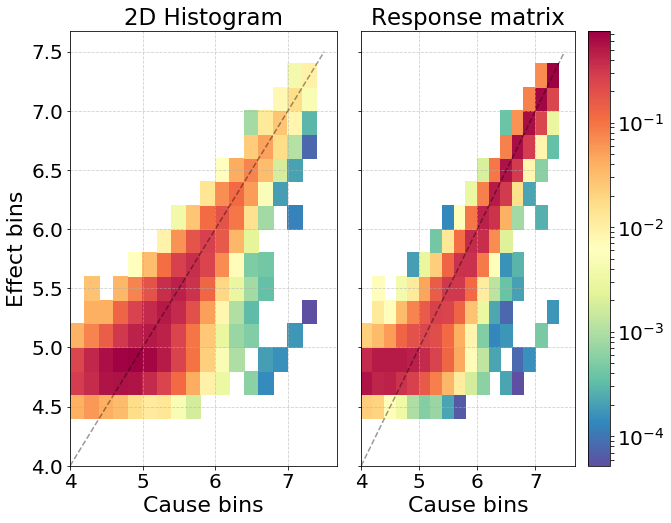

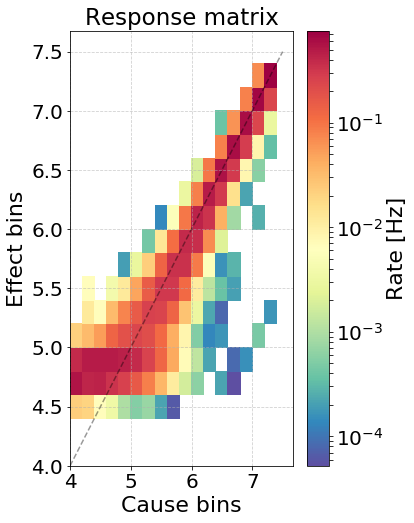

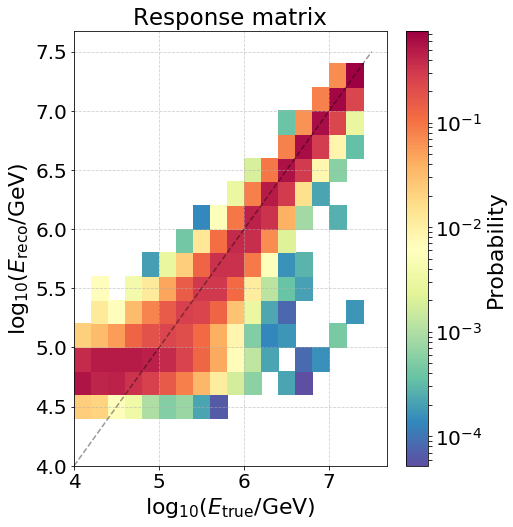

In [17]:
"""
Accent, Accent_r, 
Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, 
CMRmap, CMRmap_r, 
Dark2, Dark2_r, 
GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, 
OrRd, OrRd_r, Oranges, Oranges_r, 
PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, 
    PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, 
    PuRd_r, Purples, Purples_r, 
RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, 
    RdYlGn_r, Reds, Reds_r, 
Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, 
Wistia, Wistia_r, 
YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, 
-----------------------
afmhot, afmhot_r, autumn, autumn_r, 
binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, 
cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, 
    cubehelix_r, 
flag, flag_r, 
gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, 
    gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, 
    gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, 
    gnuplot2_r, gnuplot_r, gray, gray_r, 
hot, hot_r, hsv, hsv_r, 
inferno, inferno_r, 
jet, jet_r, 
magma, magma_r, 
nipy_spectral, nipy_spectral_r, 
ocean, ocean_r, 
pink, pink_r, plasma, plasma_r, prism, prism_r, 
rainbow, rainbow_r, 
seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, 
terrain, terrain_r, 
viridis, viridis_r, 
winter, winter_r
"""
# 'Spectral_r', 'bwr', 'jet', 
cmap = 'Spectral_r'

X, Y = numpy.meshgrid(loge_bins, loge_bins)
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[:3, :2])
ax2 = plt.subplot(gs[:3, 2:4])

# =========True Vs Reco Energy Histogram=============
ax1.pcolormesh(X,Y,response_hist, norm=LogNorm(), cmap=cmap)
ax1.set(xlabel='Cause bins', ylabel='Effect bins',
       title='2D Histogram')
ax1.grid()
ax1.plot([4,7.5], [4,7.5], 'k--', alpha=0.4)
ax1.set_xticks(numpy.linspace(4.0,7.0,4))
ax1.grid(linestyle='--', alpha=0.6)
# =========Response Matrix=============
pcm = ax2.pcolormesh(X,Y,response, norm=LogNorm(), cmap=cmap)
ax2.set(xlabel='Cause bins', title='Response matrix')
ax2.set_yticklabels([])
ax2.grid()
ax2.plot([4,7.5], [4,7.5], 'k--', alpha=0.4)
ax2.set_xticks(numpy.linspace(4.0,7.0,4))
ax2.grid(linestyle='--', alpha=0.6)
plt.colorbar(pcm)
if savefig:
    figname='response_matrix_%s_%s_len%i%s'%(composition_model,particle,lenbins,name)+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')

# ====== response matrix only =========
plt.figure(figsize=(5,8))
pcm = plt.pcolormesh(X,Y,response, norm=LogNorm(), cmap=cmap)
ax = plt.gca()
ax.set(xlabel='Cause bins', ylabel='Effect bins', title='Response matrix')
plt.grid(linestyle='--', alpha=0.6)
plt.plot([4,7.5], [4,7.5], 'k--', alpha=0.4)
ax.set_xticks(numpy.linspace(4.0,7.0,4))
plt.colorbar(pcm, label='Rate [Hz]')
if savefig:
    plt.savefig(rfr_savedir+'response_matrix_only_%s_%s_len%i%s'%(composition_model,particle,lenbins,name)+'.png', 
                bbox_inches='tight')

# ====== response matrix only =========
plt.figure(figsize=(7,8))
pcm = plt.pcolormesh(X,Y,response, norm=LogNorm(), cmap=cmap)
ax = plt.gca()
ax.set(xlabel=r'log$_{10}(E_{\rm true}/\rm GeV)$', ylabel=r'log$_{10}(E_{\rm reco}/\rm GeV)$', title='Response matrix')
plt.grid(linestyle='--', alpha=0.6)
plt.plot([4,7.5], [4,7.5], 'k--', alpha=0.4)
ax.set_xticks(numpy.linspace(4.0,7.0,4))
plt.colorbar(pcm, label='Probability')
if savefig:
    plt.savefig(rfr_savedir+'response_matrix_only_%s_%s_len%i%s'%(composition_model,particle,lenbins,'14feb2019')+'.png', 
                bbox_inches='tight')


Iteration 1: ts = 0.3954, ts_stopping = 0.001
Iteration 2: ts = 0.0422, ts_stopping = 0.001
Iteration 3: ts = 0.0127, ts_stopping = 0.001
Iteration 4: ts = 0.0071, ts_stopping = 0.001
Iteration 5: ts = 0.0050, ts_stopping = 0.001
Iteration 6: ts = 0.0037, ts_stopping = 0.001
Iteration 7: ts = 0.0028, ts_stopping = 0.001
Iteration 8: ts = 0.0021, ts_stopping = 0.001
Iteration 9: ts = 0.0017, ts_stopping = 0.001
Iteration 10: ts = 0.0013, ts_stopping = 0.001
Iteration 11: ts = 0.0010, ts_stopping = 0.001
Iteration 12: ts = 0.0008, ts_stopping = 0.001
sys_error [6.36023470e-04 1.87538161e-04 4.59159417e-05 1.59157118e-05
 6.94553507e-06 3.05151918e-06 1.16056931e-06 5.20703057e-07
 2.47367937e-07 1.25390160e-07 5.41962987e-08 2.11005263e-08
 8.42589901e-09 3.36650465e-09 1.38048061e-09 6.43623897e-10
 2.32871084e-10]
sys_low_frac [1.14606381 1.66571591 2.03865673 2.03171149 1.6144365  0.92032973
 0.274955   0.07286151 0.07596256 0.08342734 0.07733254 0.05361545
 0.03164643 0.03090318 0.03

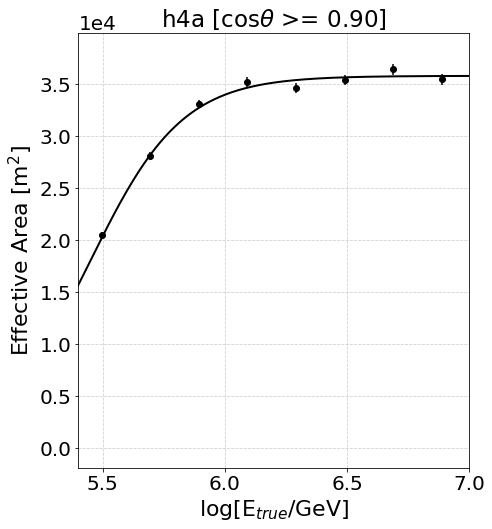

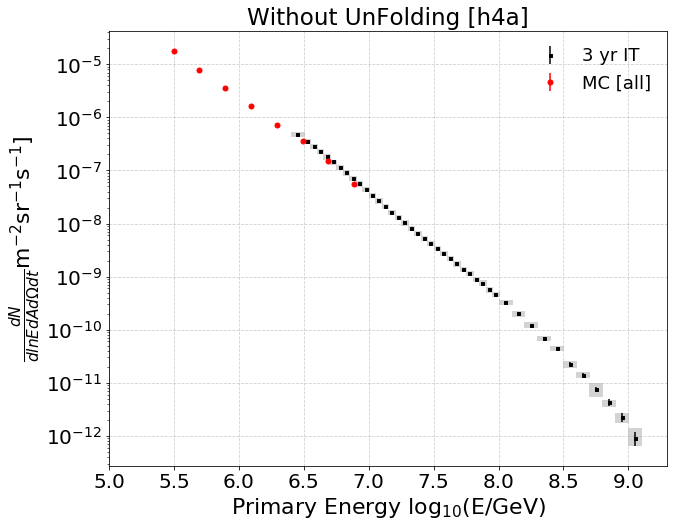

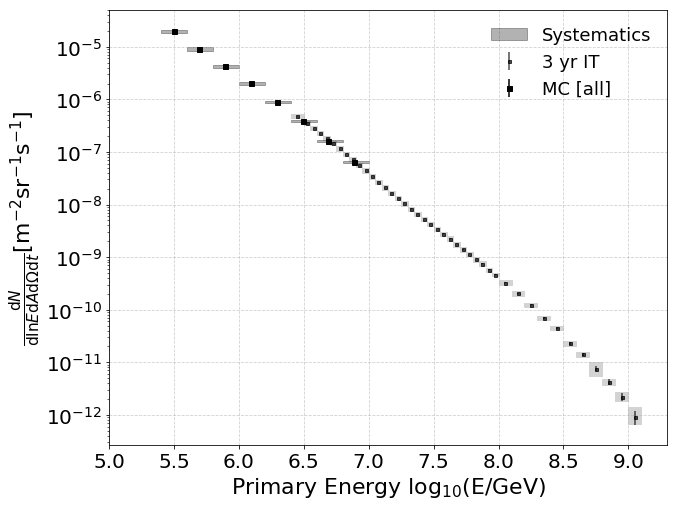

In [18]:
scale     = 1

# =============== Scale 3 yrs IT Spectrum Result ================
scaling_factor = (10**H4a_E)**(scale-1)
Flux           = H4a_Flux*scaling_factor
Error_flux     = H4a_Flux_err*scaling_factor
Syst_err_high  = Syst_high * scaling_factor
Syst_err_low   = Syst_low * scaling_factor

# Calculate Flux. Both before and after unfolding.
# ===================== Before Unfolding ===================== 
penergy_y   = unscaled_py.copy()
tenergy_y   = unscaled_ty.copy()
error_eney  = unscaled_err_py.copy()
error_enety = unscaled_err_ty.copy()

reg_fx  = cr_flux(penergy_y,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
reg_err = cr_flux(error_eney,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
t_fx    = cr_flux(tenergy_y,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
t_err   = cr_flux(error_enety,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
# ===================== After Unfolding ===================== 
unfolded_result = pyunfold.iterative_unfold(data=penergy_y,
                                   data_err=numpy.nan_to_num(error_eney),
                                   response=response,
                                   response_err=response_err,
                                   efficiencies=efficiencies,
                                   efficiencies_err=efficiencies_err,
                                   prior=prior,
                                   ts=ts, ts_stopping=ts_stopping,
                                   callbacks=callbacks,
                                   max_iter=max_iter,
                                   return_iterations=return_iterations
                                  )

if return_iterations:
    maxiter = max(unfolded_result['num_iterations'])
    unfolded= unfolded_result['unfolded'][maxiter-1]
    stat_err= unfolded_result['stat_err'][maxiter-1]
    sys_err = unfolded_result['sys_err'][maxiter-1]
    unfolding_matrix = unfolded_result['unfolding_matrix'][maxiter-1]
        
else:
    unfolded= unfolded_result['unfolded']
    stat_err= unfolded_result['stat_err']
    sys_err = unfolded_result['sys_err']
    unfolding_matrix = unfolded_result['unfolding_matrix']
    
flux       = cr_flux(unfolded,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2
                 )
stat_error = cr_flux(stat_err,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2
                 )
sys_error  = cr_flux(sys_err,
                  loge_bins=loge_bins,
                  Aeff=Aeff,
                  cos1=cos1, cos2=cos2
                 )
'''
hf          = tables.open_file('systematic_uncertainty%s.h5'%name, 'a')
if 'unfolding_uncertainty_mc' in hf.root:
    hf.remove_node('/', 'unfolding_uncertainty_mc')
hf.create_array('/', 'unfolding_uncertainty_mc', sys_error/flux)
hf.close()'''

# ================== Plot Effective Area ====================
plt.figure(figsize=(7,8))
effx = numpy.linspace(4,7.0,501)
plt.errorbar(mid_logE, AeffO, yerr=ErrAeff, color='k', marker='o', linestyle='')
plt.plot(effx, sigmoid_func(effx, *popt_eff), 'k', lw=2)
plt.xlabel(r'log[E$_{true}$/GeV]')
plt.ylabel(r'Effective Area [m$^2$]')
plt.title(r'%s [cos$\theta$ >= %.2f]'%(composition_model, cos2))
plt.xlim(5.4,7.0)
plt.grid(linestyle='--', alpha=0.6)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if savefig:
    figname='effective_area_%s_%s_len%i%s'%(composition_model,particle,lenbins,name)+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')


# ==================== Plot Flux Before Unfolding ====================
plt.figure(figsize=(10,8))
plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', markersize=3, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], 
                     color='lightgrey') 
plt.errorbar(mid_logE[ene_mask], reg_fx[ene_mask], yerr=reg_err[ene_mask], markersize=5,
                 color='r', fmt=' ', marker='o', label='MC ['+particle+']')
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
plt.xticks(numpy.linspace(4,9, 11))
plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
if scale==1:
    plt.ylabel(r'$\frac{dN}{dlnE dA d\Omega dt}$'+\
               r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
else:
    plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rmGeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
plt.legend(loc='best', frameon=False)
plt.grid(linestyle='--', alpha=0.6)
plt.title('Without UnFolding [%s]'%composition_model)
plt.xlim(5.0,9.3)
plt.yscale('log')
if savefig:
    figname='CR_flux_without_unfolding_%s_%s_len%i_%s'%(composition_model,particle,lenbins,name)+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')
    
# ==================== Plot Flux After Unfolding ====================
# Note: Fraction of composition systematics is calculated in systematics_study.ipynb
STA2_midE = mid_logE_mc[ene_mask]
bin_width = numpy.diff(mid_logE_mc)[0]
STA2_loge = loge_bins[numpy.where((loge_bins>=STA2_midE[0]-bin_width)*(loge_bins<=STA2_midE[-1]+bin_width))]
STA2_flux = flux[ene_mask]
STA2_err  = stat_error[ene_mask]
# ===Quadrature Sum of Systematics===
if len(mid_logE)==34:
    sys_error = numpy.zeros(34) # DONOT plot systematics for 0.1 ene bins
    
# sys_vemcal_low_frac, sys_vemcal_high_frac 

sys_low_frac  = systematics_quadrature([sys_error/flux, sys_total_low_frac])
sys_high_frac = systematics_quadrature([sys_error/flux, sys_total_high_frac])

print 'sys_error', sys_error
print 'sys_low_frac', sys_low_frac

STA2_sys_low  = (sys_low_frac*flux)[ene_mask]
STA2_sys_high = (sys_high_frac*flux)[ene_mask]

# ============Print Result=============
print 'NEobs Rate'
print NEobs_rate[ene_mask]
print 'Unfolded NE Rate'
print unfolded[ene_mask]
print 'Flux'
print STA2_flux
print 'stat error'
print STA2_err
print 'sys low'
print STA2_sys_low
print 'sys high'
print STA2_sys_high

plt.figure(figsize=(10,8))
plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', alpha=0.7, fmt='s', markersize=3, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], color='lightgrey') 
plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
             fmt='s', markersize=5, label='MC ['+particle+']')

for i in range(int(sum(ene_mask))):
    if i==0:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3, label='Systematics') 
    else:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3,)
        
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 
    
plt.yscale('log')
plt.xticks(numpy.linspace(4,9, 11))
plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
if scale==1:
    plt.ylabel(r'$\frac{{\rm d}N}{{\rm dln}E {\rm d}A {\rm d}\Omega {\rm d}t}$'+\
               r'[$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
else:
    plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rmGeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
plt.legend(loc='best', frameon=False)
plt.grid(linestyle='--', alpha=0.6)
plt.xlim(5.0,9.3)
if savefig:
    figname='CR_flux_unfolded_%s_%s_len%i_%s'%(composition_model,particle,lenbins,name)+'.png'
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')


hf = tables.open_file(rfr_savedir+'unfolding_flux_result%s.h5'%name, 'w')
hf.create_array('/', 'mid_logE_len%i'%lenbins, mid_logE)
hf.create_array('/', 'loge_bins_len%i'%lenbins, loge_bins)
hf.create_array('/', 'Aeff_len%i'%lenbins, Aeff)
hf.create_array('/', 'ErrAeff_len%i'%lenbins, ErrAeff)
hf.create_array('/', 'coszenith_len%i'%lenbins, numpy.array([cos1,cos2]))
hf.create_array('/', 'flux_mc_len%i'%lenbins, flux)
hf.create_array('/', 'stat_error_mc_len%i'%lenbins, stat_error)
hf.create_array('/', 'unfolding_matrix_mc_len%i'%lenbins, unfolding_matrix)
hf.close()


In [19]:
unfolded_result

,num_iterations,stat_err,sys_err,ts_iter,ts_stopping,unfolded,unfolding_matrix
0,1,"[0.002084340577208974, 0.0018266089270519402, ...","[0.003634107280684148, 0.0016590526315207184, ...",0.395367,0.001,"[0.09777644053776886, 0.11966735257768404, 0.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2,"[0.002026329741792326, 0.0019850444781387925, ...","[0.004975181846235252, 0.0026438537749116937, ...",0.042247,0.001,"[0.07462380902779092, 0.10772785161243162, 0.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,3,"[0.0020337235584790728, 0.0021115421957362307,...","[0.005374779716488935, 0.0031716634645689713, ...",0.012705,0.001,"[0.05958620960524805, 0.09613567323016027, 0.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,4,"[0.002025226487947269, 0.0022010824033175357, ...","[0.005452934359059067, 0.003469764102538466, 0...",0.007142,0.001,"[0.04988694659114006, 0.0872599003546667, 0.12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,5,"[0.0020368636420533353, 0.0022979677868254092,...","[0.005418710211711755, 0.003654092461630144, 0...",0.004951,0.001,"[0.04334700527361885, 0.08062428981520196, 0.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,6,"[0.0020637593575274964, 0.0024061707285065216,...","[0.0053491794243331545, 0.003781260269406154, ...",0.003652,0.001,"[0.038760983239585906, 0.07562185912053981, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,7,"[0.0021034284699587144, 0.0025259152688914504,...","[0.005274649409903473, 0.003879763711221485, 0...",0.002769,0.001,"[0.03544360843187953, 0.07180137775582277, 0.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,8,"[0.002153477911286037, 0.002655943219477705, 0...","[0.005207023495401543, 0.0039645360540975436, ...",0.002137,0.001,"[0.03298455874845178, 0.06884798970587631, 0.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,9,"[0.0022120031246476027, 0.0027947679558589923,...","[0.005150480705605679, 0.004043648301431761, 0...",0.001670,0.001,"[0.03112620731625169, 0.06654123277625847, 0.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,10,"[0.0022774814926626663, 0.0029409825458382656,...","[0.005105878658178506, 0.004121533802448478, 0...",0.001318,0.001,"[0.029700089972025775, 0.06472408033209376, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


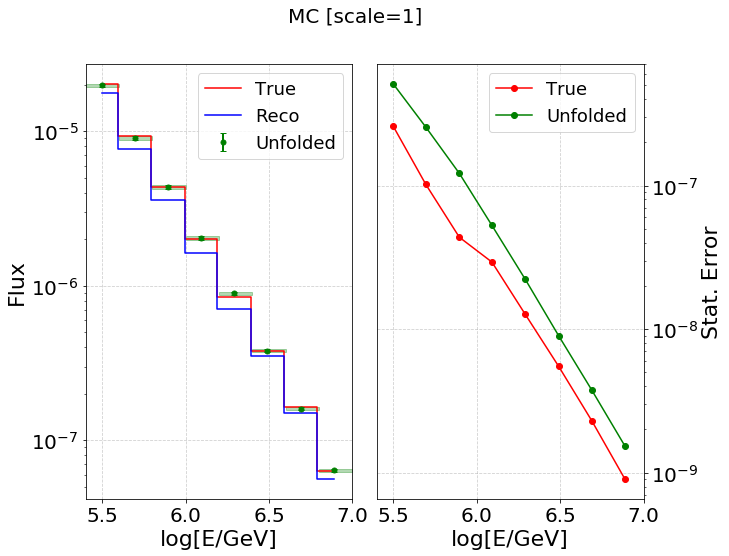

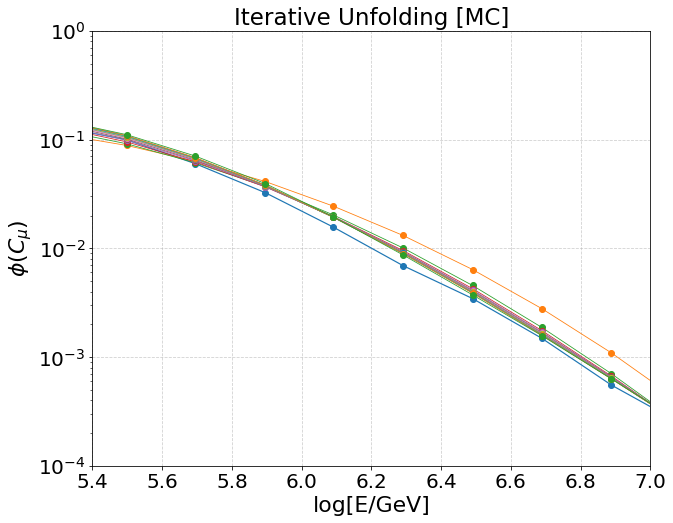

In [20]:
#plt.rcParams.update({'xtick.labelsize':20})
plt.rcParams.update({'figure.figsize':(10, 8)})


fig = plt.figure()
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[:3, :2])
ax2 = plt.subplot(gs[:3, 2:4])

ax1.step(mid_logE[ene_mask], t_fx[ene_mask],   color='r', label='True'    , lw=1.5, where='mid')
ax1.step(mid_logE[ene_mask], reg_fx[ene_mask], color='b', label='Reco' , lw=1.5, where='mid')
ax1.errorbar(mid_logE[ene_mask], flux[ene_mask], yerr=stat_error[ene_mask], 
             color='g', label='Unfolded',
             elinewidth=2,
             capsize=3,
             ls='None', marker='.', ms=10)
ax1.set_yscale('log')
ax1.set_xlabel('log[E/GeV]')
ax1.set_ylabel('Flux')
ax1.set_xticks(numpy.linspace(4.0,7.0,7))
ax1.set_xlim(5.4, 7.0)
ax1.legend(loc='best')
ax1.grid(linestyle='--', alpha=0.6)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
for i in range(int(sum(ene_mask))):                                                                                                                                                    
    ax1.fill_between(STA2_loge[i:i+2], (STA2_flux-sys_error[ene_mask])[i], 
                     (STA2_flux+sys_error[ene_mask])[i], color='g', alpha=0.3) 

ax2.plot(mid_logE[ene_mask], t_err[ene_mask], 'ro-', 
         label='True', lw=1.5)
ax2.plot(mid_logE[ene_mask], stat_error[ene_mask], 'go-', 
         label='Unfolded', lw=1.5)
ax2.set_xlabel('log[E/GeV]')
ax2.set_ylabel('Stat. Error')
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")
ax2.set_xticks(numpy.linspace(4.0,7.0,7))
ax2.set_xlim(5.4, 7.0)
ax2.set_yscale('log')
ax2.legend(loc='best')
ax2.grid(linestyle='--', alpha=0.6)
plt.suptitle('MC [scale=%.0f]'%scale, fontsize=20)
if savefig:
    fn='unfolding_stat_error_comparison_%s_%s_len%i_%s.png'%(composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+fn, bbox_inches = 'tight')

if return_iterations:
    plt.figure()
    #plt.plot(mid_logE, prior, label='Prior', marker='o', lw=1.2)
    plt.plot(mid_logE, penergy_y, label='MC Reco', marker='o', lw=1.2)
    for i in range(maxiter):
        plt.plot(mid_logE, unfolded_result['unfolded'][i], marker='o', 
                 label='Iter:%i'%(i+1), lw=0.8)
    #plt.legend(loc='best')
    plt.grid(linestyle='--', alpha=0.6)
    plt.yscale('log')
    plt.xlim(5.4,7.0)
    plt.ylim(1e-4,1e0)
    plt.xlabel('log[E/GeV]')
    plt.ylabel(r'$\phi(C_\mu)$')
    plt.title('Iterative Unfolding [MC]')
    if savefig:
        figname='unfolding_iteration_spectrum_%s_%s_len%i_%s.png'%(composition_model,particle,lenbins,name)
        plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')

    # ======Unfolding Matrix========
    if plot_unfolding:
        X,Y = numpy.meshgrid(loge_bins, loge_bins)
        for i in range(maxiter):
            if i==(maxiter-1):
                plt.figure(figsize=(6,8))
                plt.pcolormesh(X, Y, unfolded_result['unfolding_matrix'][i], norm=LogNorm(), 
                               cmap='Spectral_r', vmin=1e-7, vmax=1e0)
                plt.xlabel('log[Etrue/GeV]')
                plt.ylabel('log[Ereco/GeV]')
                plt.grid(linestyle='--', alpha=0.6)
                plt.title('Unfolding Matrix [MC, %i]'%(i+1))
                plt.plot([4,7.5], [4,7.5], 'k--', lw=1.5, alpha=0.3)
                plt.colorbar()
                ax = plt.gca()
                ax.set_xticks(numpy.linspace(4.0,7.0,4))
                if savefig:
                    fn='unfolding_matrix_mc_iter%i_%s_%s_len%i_%s.png'%((i+1),composition_model,particle,lenbins,name)
                    plt.savefig(rfr_savedir+fn, bbox_inches = 'tight')


Energy spectrum of MC data before and after unfolding.

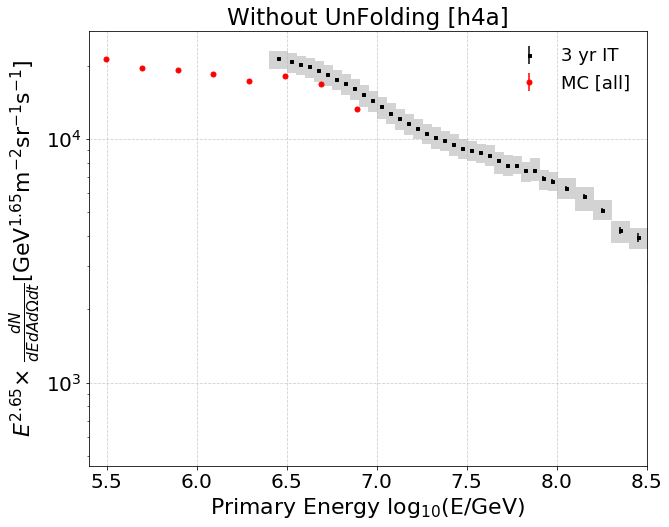

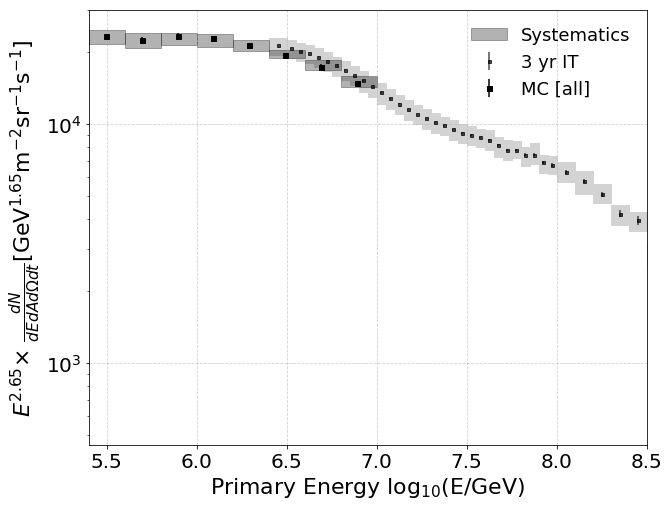

In [21]:
scale     = 2.65

# ---------------------------------------                                                                                                                                       
# 3 year IT spectrum (received from serap)                                                                                                                                      
# H4a_Flux = dN/(dlnE dOmega dA dt)                                                                                                                                             
# --------------------------------------- 
scale_factor_mc  = scale_factor_func(scaleE_mc, scale)
scale_factor_3yr = scale_factor_func(scaleE_3yr, scale)

Flux             = H4a_Flux*scale_factor_3yr
Error_flux       = H4a_Flux_err*scale_factor_3yr
Syst_err_high    = Syst_high*scale_factor_3yr
Syst_err_low     = Syst_low*scale_factor_3yr

# Calculate Flux. Both Unfolded and without unfolding.
# =============== Before Unfolding  ===============

penergy_y   = numpy.histogram(penergy, bins=loge_bins, 
                              weights=((10**penergy)**(scale-1)*weight))[0]
tenergy_y   = numpy.histogram(tenergy, bins=loge_bins, 
                              weights=((10**tenergy)**(scale-1)*weight))[0]
error_eney   = unscaled_err_py*scale_factor_mc
error_enety  = unscaled_err_ty*scale_factor_mc

reg_fx  = cr_flux(penergy_y , loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
reg_err = cr_flux(error_eney, loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
t_fx    = cr_flux(tenergy_y , loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)
t_err   = cr_flux(error_enety,loge_bins=loge_bins, Aeff=Aeff, cos1=cos1, cos2=cos2)

# =============== After Unfolding ===============
flux = scale_factor_mc*flux
stat_error = scale_factor_mc*stat_error
#sys_error  = scale_factor_mc*sys_error
STA2_flux = flux[ene_mask]
STA2_err  = stat_error[ene_mask]
STA2_sys_low  = (scale_factor_mc[ene_mask])*STA2_sys_low
STA2_sys_high = (scale_factor_mc[ene_mask])*STA2_sys_high

# ==================== Plot Flux Before Unfolding ====================
plt.figure()
plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', markersize=3, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], 
                     color='lightgrey') 
plt.errorbar(mid_logE[ene_mask], reg_fx[ene_mask], yerr=reg_err[ene_mask], markersize=5,
                 color='r', fmt=' ', marker='o', label='MC ['+particle+']')
plt.xticks(numpy.linspace(4,9, 11))
plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rm GeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}sr^{-1}s^{-1}$]')

plt.legend(loc='best', frameon=False)
plt.grid(linestyle='--', alpha=0.6)
plt.title('Without UnFolding [%s]'%composition_model)
plt.xlim(5.4,8.5)
plt.yscale('log')
if savefig:
    figname='CR_flux_without_unfolding_scale%.2f_%s_%s_len%i_%s.png'%(scale,composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')
    
# ==================== Plot Flux After Unfolding ====================

plt.figure()
plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', alpha=0.7, fmt='s', markersize=3, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], color='lightgrey') 
plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
             fmt='s', markersize=5, label='MC ['+particle+']')
for i in range(int(sum(ene_mask))):
    if i==0:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3, label='Systematics') 
    else:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                     (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.3,)
        
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

if plot_h4a:
    model_scaling_factor = scale_factor_func(10**model_bin, scale)
    model_h4a  = (model_scaling_factor*H4a(particle='all', E=10**model_bin))
    plt.plot(model_bin, model_h4a, 'r--', label='H4a', alpha=0.4)
    
plt.yscale('log')
plt.xticks(numpy.linspace(4,9, 11))
plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)')
plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rm GeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}sr^{-1}s^{-1}$]')
plt.legend(loc='best', frameon=False)
plt.grid(linestyle='--', alpha=0.6)
plt.xlim(5.4,8.5)
if savefig:
    figname='CR_flux_unfolded_scale%.2f_%s_%s_len%i_%s.png'%(scale,composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')

if savehdf:
    hf = tables.open_file('flux_storage_temp%s.h5'%name, 'a')
    namemidE = 'STA2_midE_mc_%s_%s'%(which_scaling,which_prior)
    namelogE = 'STA2_loge'
    nameflux = 'STA2_flux_mc_%s_%s_%s'%(which_scaling,which_prior,particle)
    namestat = 'STA2_stat_mc_%s_%s_%s'%(which_scaling,which_prior,particle)
    namesysL = 'STA2_sys_low_mc_%s_%s_%s'%(which_scaling,which_prior,particle)
    namesysH = 'STA2_sys_high_mc_%s_%s_%s'%(which_scaling,which_prior,particle)
    nameAeff = 'Aeff_len%i_%s'%(len(mid_logE), particle)
    nameErrAeff= 'ErrAeff_len%i_%s'%(len(mid_logE), particle)
    nameAeff_popt   = 'popt_%s'%particle
    if cos2!=0.9:
        nameAeff = 'Aeff_len%i_%s_%s'%(len(mid_logE), particle, str(int(100*cos2)))
        nameErrAeff= 'ErrAeff_len%i_%s_%s'%(len(mid_logE), particle, str(int(100*cos2)))
        nameAeff_popt   = 'popt_%s_%s'%(particle, str(int(100*cos2)))

    if namemidE in hf.root:
        hf.remove_node('/', namemidE)
    if namelogE in hf.root:
        hf.remove_node('/', namelogE)
    if nameflux in hf.root:
        hf.remove_node('/', nameflux)
    if namestat in hf.root:
        hf.remove_node('/', namestat)
    if namesysL in hf.root:
        hf.remove_node('/', namesysL)
    if namesysH in hf.root:
        hf.remove_node('/', namesysH)
    if nameAeff in hf.root:
        hf.remove_node('/', nameAeff)
    if nameErrAeff in hf.root:
        hf.remove_node('/', nameErrAeff)
    if nameAeff_popt in hf.root:
        hf.remove_node('/', nameAeff_popt)
    hf.create_array('/', namemidE, STA2_midE)
    hf.create_array('/', namelogE, STA2_loge)
    hf.create_array('/', nameflux, STA2_flux)
    hf.create_array('/', namestat, STA2_err)
    hf.create_array('/', namesysL, STA2_sys_low)
    hf.create_array('/', namesysH, STA2_sys_high)
    hf.create_array('/', nameAeff, AeffO)
    hf.create_array('/', nameErrAeff, ErrAeff)
    hf.create_array('/', nameAeff_popt, popt_eff)
    hf.close()




Comapre true energy distribution with energy distribution after unfolding. Ideally, both distribution should be comparable. Plot on right hand side is the statistical error calculated for true energy distribution and taking into account of change in energy distribution in each iteration.

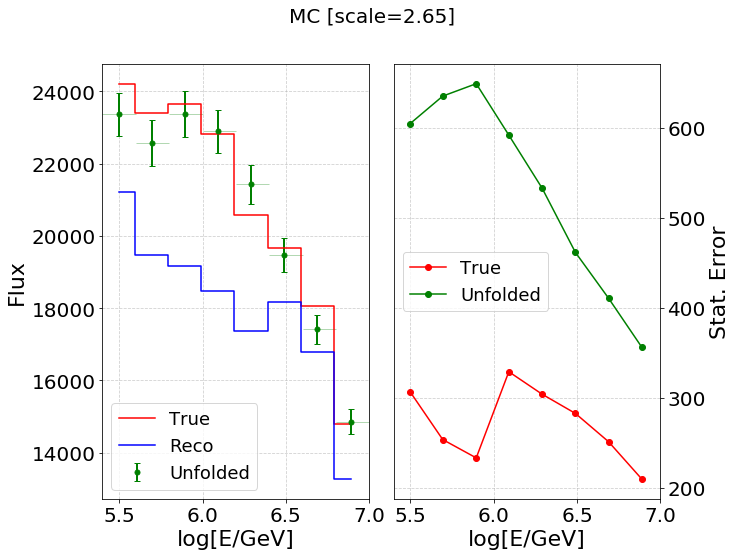

In [22]:
if True:
    fig = plt.figure()
    gs = gridspec.GridSpec(3, 4)
    ax1 = plt.subplot(gs[:3, :2])
    ax2 = plt.subplot(gs[:3, 2:4])

    ax1.step(mid_logE[ene_mask], t_fx[ene_mask],   color='r', label='True'    , lw=1.5, where='mid')
    ax1.step(mid_logE[ene_mask], reg_fx[ene_mask], color='b', label='Reco' , lw=1.5, where='mid')
    ax1.errorbar(mid_logE[ene_mask], flux[ene_mask], yerr=stat_error[ene_mask], 
                 color='g', label='Unfolded',
                 elinewidth=2,
                 capsize=3,
                 ls='None', marker='.', ms=10, )

    #ax1.set_yscale('log')
    ax1.set_xlabel('log[E/GeV]')
    ax1.set_ylabel('Flux')
    ax1.set_xticks(numpy.linspace(4,7.0,7))
    ax1.set_xlim(5.4, 7.0)
    ax1.legend(loc='best')
    ax1.grid(linestyle='--', alpha=0.6)
    for i in range(int(sum(ene_mask))):                                                                                                                                                    
        ax1.fill_between(STA2_loge[i:i+2], (STA2_flux-sys_error[ene_mask])[i], 
                         (STA2_flux+sys_error[ene_mask])[i], color='g', alpha=0.3) 

    ax2.plot(mid_logE[ene_mask], t_err[ene_mask], 'ro-', 
             label='True', lw=1.5)
    ax2.plot(mid_logE[ene_mask], stat_error[ene_mask], 'go-', 
             label='Unfolded', lw=1.5)
    ax2.set_xlabel('log[E/GeV]')
    ax2.set_ylabel('Stat. Error')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.set_ticks_position("right")
    ax2.set_xticks(numpy.linspace(4.0,7.0,7))
    #ax2.set_yscale('log')
    ax2.set_xlim(5.4, 7.0)
    ax2.legend(loc='best')
    ax2.grid(linestyle='--', alpha=0.6)
    plt.suptitle('MC [scale=%.2f]'%scale, fontsize=20)

Iteration 1: ts = 0.3914, ts_stopping = 0.001
Iteration 2: ts = 0.0424, ts_stopping = 0.001
Iteration 3: ts = 0.0128, ts_stopping = 0.001
Iteration 4: ts = 0.0072, ts_stopping = 0.001
Iteration 5: ts = 0.0050, ts_stopping = 0.001
Iteration 6: ts = 0.0037, ts_stopping = 0.001
Iteration 7: ts = 0.0028, ts_stopping = 0.001
Iteration 8: ts = 0.0022, ts_stopping = 0.001
Iteration 9: ts = 0.0017, ts_stopping = 0.001
Iteration 10: ts = 0.0013, ts_stopping = 0.001
Iteration 11: ts = 0.0011, ts_stopping = 0.001
Iteration 12: ts = 0.0008, ts_stopping = 0.001

Unfolding systematic uncertainty [%]
	high: [2.78 3.07 3.43 3.22 2.71 2.54 2.34 2.11]
	low: [2.78 3.07 3.43 3.22 2.71 2.54 2.34 2.11]

Total systematic uncertainty [%]
	high: [6.62 7.48 3.92 4.7  5.45 4.98 6.5  6.89]
	low: [7.34 7.73 8.55 7.95 5.52 3.4  3.25 3.18]
NEobs Rate
[0.11565617 0.07127499 0.03926328 0.01847548 0.00836777 0.00436701
 0.00184312 0.00066609]
Unfolded NE Rate
[0.12735798 0.08252664 0.04697985 0.02330312 0.01051823 0.00

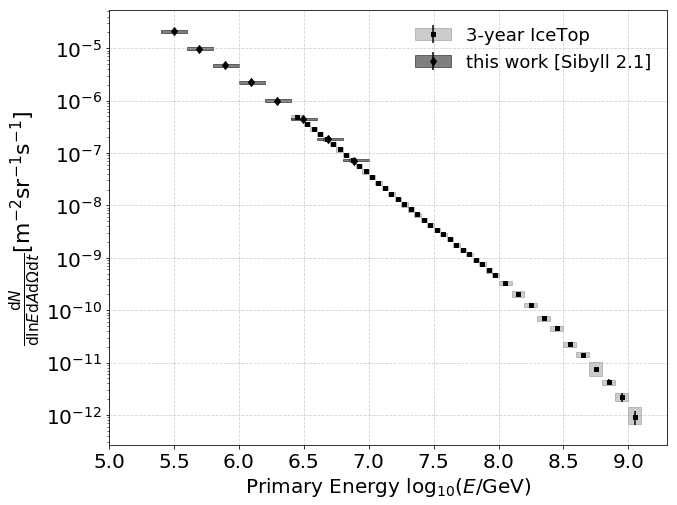

In [23]:
scale    = 1

# ================== Scale 3yr Spectrum ====================
scaling_factor = (10**H4a_E)**(scale-1)
Flux = H4a_Flux*scaling_factor
Error_flux = H4a_Flux_err*scaling_factor
Syst_err_high = Syst_high * scaling_factor
Syst_err_low = Syst_low * scaling_factor


# ================= Data Flux after Unfolding =================
unfolded_result = pyunfold.iterative_unfold(data=NEobs_rate,
                                   data_err=numpy.nan_to_num(NEobs_rate_err),
                                   response=response,
                                   response_err=response_err,
                                   efficiencies=efficiencies,
                                   efficiencies_err=efficiencies_err,
                                   prior=prior,
                                   ts=ts, ts_stopping=ts_stopping,
                                   callbacks=callbacks,
                                   max_iter=max_iter,
                                   return_iterations=return_iterations
                                  )

if return_iterations:
    maxiter = max(unfolded_result['num_iterations'])
    unfolded= unfolded_result['unfolded'][maxiter-1]
    stat_err= unfolded_result['stat_err'][maxiter-1]
    sys_err = unfolded_result['sys_err'][maxiter-1]
    unfolding_matrix = unfolded_result['unfolding_matrix'][maxiter-1]
        
else:
    unfolded= unfolded_result['unfolded']
    stat_err= unfolded_result['stat_err']
    sys_err = unfolded_result['sys_err']
    unfolding_matrix = unfolded_result['unfolding_matrix']
    
expflux  = cr_flux(unfolded,
                   loge_bins=loge_bins,
                   Aeff=Aeff,
                   cos1=cos1, cos2=cos2
                 )*pressure_correction_factor
stat_experr = cr_flux(stat_err,
                   loge_bins=loge_bins,
                   Aeff=Aeff,
                   cos1=cos1, cos2=cos2
                 )
sys_experror= cr_flux(sys_err,
                   loge_bins=loge_bins,
                   Aeff=Aeff,
                   cos1=cos1, cos2=cos2
                 )

'''hf          = tables.open_file('systematic_uncertainty%s.h5'%name, 'a')
print 'saving unfolding_uncertainty_exp in systematic_uncertainty%s.h5'%name
if 'unfolding_uncertainty_exp' in hf.root:
    hf.remove_node('/', 'unfolding_uncertainty_exp')
hf.create_array('/', 'unfolding_uncertainty_exp', sys_experror/expflux)
hf.close()'''

# =================== Make Flux easy to Read ======================

STA2_midE = mid_logE_exp[ene_mask]
bin_width = numpy.diff(mid_logE_mc)[0]
STA2_loge = loge_bins[numpy.where((loge_bins>=STA2_midE[0]-bin_width)*(loge_bins<=STA2_midE[-1]+bin_width))]
STA2_flux = expflux[ene_mask]
STA2_err  = stat_experr[ene_mask]
# ===Quadrature Sum of Systematics===
if len(mid_logE)==34:
    sys_experror = numpy.zeros(34) # DONOT plot systematics for 0.1 ene bins
# sys_vemcal_low_frac, sys_vemcal_high_frac
sys_low_frac  = systematics_quadrature([sys_experror/expflux, sys_total_low_frac])
sys_high_frac = systematics_quadrature([sys_experror/expflux, sys_total_high_frac])
STA2_sys_low  = (sys_low_frac*expflux)[ene_mask]
STA2_sys_high = (sys_high_frac*expflux)[ene_mask]

print '\nUnfolding systematic uncertainty [%]'
print '\thigh:', numpy.around(100*(sys_experror/expflux)[ene_mask], 2)
print '\tlow:', numpy.around(100*(sys_experror/expflux)[ene_mask], 2)

print '\nTotal systematic uncertainty [%]'
print '\thigh:', numpy.around(100*sys_high_frac[ene_mask], 2)
print '\tlow:', numpy.around(100*sys_low_frac[ene_mask], 2)

# ============Print Result=============
print 'NEobs Rate'
print NEobs_rate[ene_mask]
print 'Unfolded NE Rate'
print unfolded[ene_mask]
print 'Flux'
print STA2_flux
print 'stat error'
print STA2_err
print 'sys low'
print STA2_sys_low
print 'sys high'
print STA2_sys_high

# ================ Plot Data Flux after Unfolding =================
plt.figure()
f1=plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', 
             markersize=4, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    ff1=plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], 
                     (Flux+Syst_err_high)[i], color='k', alpha=0.2) 
f2=plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
             fmt='d', markersize=6, label='this work [Sibyll2.1]')
plt.xlim(5.0,9.3)
if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    plt.xlim(4.0,9.3)
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

for i in range(int(sum(ene_mask))):
    if i==0:
        ff2=plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5, 
                         label='Systematics') 
    else:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5)

#plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)', fontsize=20)
#plt.ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
#               r'[$GeV^{'+str(scale-1)+'}$' +r'm$^{-2}sr^{-1}s^{-1}$]',
#               fontsize=22)
plt.xlabel('Primary Energy ' +r'log$_{10}(E/\rm GeV)$', fontsize=20)
if scale==1:
    plt.ylabel(r'$\frac{{\rm d}N}{{\rm dln}E {\rm d}A {\rm d}\Omega {\rm d}t}$'+\
               r'[$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
else:
    plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rmGeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
plt.yscale('log')
#plt.legend(loc='best', frameon=False)
plt.legend([(f1,ff1), (f2,ff2)], ['3-year IceTop', 'this work [Sibyll 2.1]'], numpoints=1, frameon=False)
plt.grid(linestyle='--', alpha=0.6)
if savefig:
    figname='CR_flux_experiment_scale%.2f_len%i%s.png'%(scale,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')

hf = tables.open_file(rfr_savedir+'unfolding_flux_result%s.h5'%name, 'a')
hf.create_array('/', 'flux_exp_len%i'%len(mid_logE), flux)
hf.create_array('/', 'stat_error_exp_len%i'%len(mid_logE), stat_error)
hf.create_array('/', 'unfolding_matrix_exp_len%i'%len(mid_logE), unfolding_matrix)
hf.close()

if savehdf:
    # This is used to calculate Bhaktiyar's style of compostion systematics.
    hf = tables.open_file('flux_storage_temp%s.h5'%name, 'a')
    nameflux = 'STA2_flux_exp_scale1_%s_%s_%s'%(which_scaling,which_prior,particle)
    if cos2==0.8:
        nameflux = 'STA2_flux_exp_scale1_%s_%s_%s_cos80_90'%(which_scaling,which_prior,particle)
    if nameflux in hf.root:
        hf.remove_node('/', nameflux)
    hf.create_array('/', nameflux, expflux)
    hf.close()



In [24]:
# ============Print Result=============
print 'Flux'
print list(expflux)
print 'stat error'
print list(stat_experr)
print 'sys low'
print list(sys_low_frac*expflux)
print 'sys high'
print list(sys_high_frac*expflux)


Flux
[0.003998100506274321, 0.003022937681863416, 0.0018575841398004232, 0.0009173656083548621, 0.00038258278946324615, 0.00014182613165832314, 5.1916610941313384e-05, 2.1083435022306414e-05, 9.793617095500151e-06, 4.8085154205437e-06, 2.2561550485293512e-06, 9.99256024455097e-07, 4.387323851350257e-07, 1.8393039285218802e-07, 7.149589277935234e-08, 2.7045121086700437e-08, 1.3277746896541353e-08]
stat error
[4.621651625621104e-06, 1.891481250696667e-06, 9.518716517860641e-07, 2.9174755826043985e-07, 1.2854713411436523e-07, 6.550405622824573e-08, 3.208285235838289e-08, 1.7634675296392463e-08, 1.2603947069715066e-08, 9.257880891262596e-09, 5.51098159597385e-09, 3.1977389830458856e-09, 2.100031392416421e-09, 1.3486250298928155e-09, 7.616481681024035e-10, 4.3913186513434845e-10, 3.388713781968218e-10]
sys low
[0.004674945792589954, 0.005041649624272016, 0.0037875383733387675, 0.0018638859186533992, 0.000617656552384786, 0.00013052911854409646, 1.4276443622157211e-05, 1.547745679801454e-06,

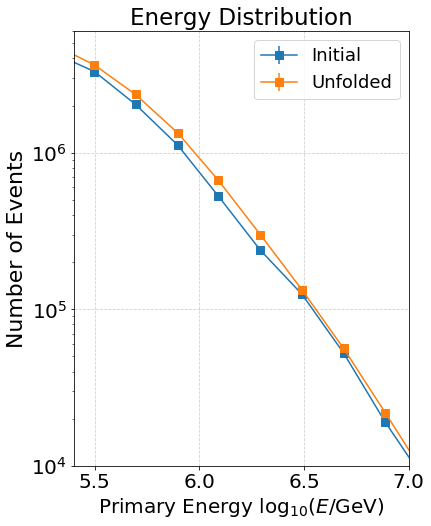

In [25]:
# ================ Unfolded Energy Distribution.  =================
plt.figure(figsize=(6,8))
plt.errorbar(mid_logE, NEobs, yerr=numpy.sqrt(NEobs), fmt='s', markersize=8, linestyle='-', lw=1.5, label='Initial')                                                                                  
plt.errorbar(mid_logE, duration*unfolded, yerr=stat_err, fmt='s', markersize=8, linestyle='-', lw=1.5, label='Unfolded')                                                                                  
plt.xlim(5.4,7.0)
plt.xlabel('Primary Energy ' +r'log$_{10}(E/\rm GeV)$', fontsize=20)
plt.ylabel(r'Number of Events')
plt.yscale('log')
plt.grid(linestyle='--', alpha=0.6)
plt.title("Energy Distribution")
plt.ylim(1e4, 6e6)
plt.legend()
if savefig:
    figname='unfolded_energy_distribution%s.png'%name
    plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')



energy bin [6.4 6.5 6.6 6.7 6.8 6.9]
% difference [6.69277576 6.33799982 5.21617957 5.41142418 7.09415769 2.81832832]


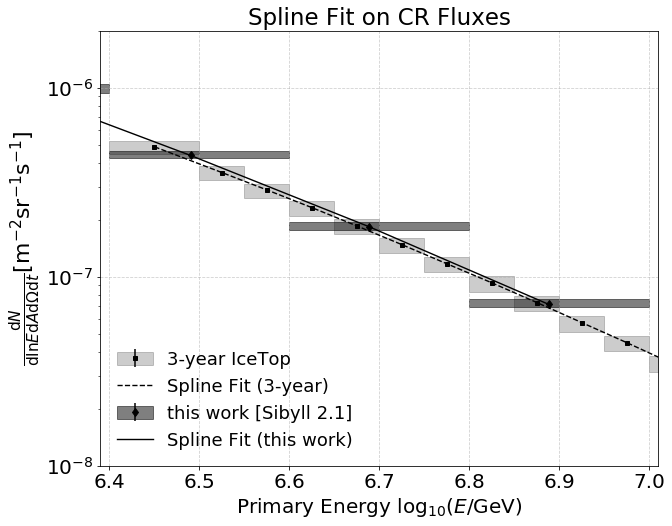

In [26]:
from scipy.interpolate import splev, splrep

spl3yr = splrep(H4a_E, Flux)
splsta2= splrep(STA2_midE, STA2_flux)

xs = numpy.linspace(6.4,6.9,6)
f3yrs = splev(xs, spl3yr)
fsta2 = splev(xs, splsta2)
print 'energy bin', xs
print '% difference', 100.*(fsta2-f3yrs)/f3yrs

plt.figure()

f1=plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', 
             markersize=4, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    ff1=plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], 
                     (Flux+Syst_err_high)[i], color='k', alpha=0.2) 
f2=plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
             fmt='d', markersize=6, label='this work [Sibyll2.1]')

for i in range(int(sum(ene_mask))):
    if i==0:
        ff2=plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5, 
                         label='Systematics') 
    else:
        plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5)

f3,=plt.plot(H4a_E, splev(H4a_E, spl3yr), 'k--', lw=1.4)
f4,=plt.plot(STA2_midE, splev(STA2_midE, splsta2), 'k', lw=1.4)

plt.xlabel('Primary Energy ' +r'log$_{10}(E/\rm GeV)$', fontsize=20)
plt.ylabel(r'$\frac{{\rm d}N}{{\rm dln}E {\rm d}A {\rm d}\Omega {\rm d}t}$'+\
               r'[$\rm m^{-2}\rm sr^{-1} \rm s^{-1}$]',
               fontsize=22)
plt.title('Spline Fit on CR Fluxes')
plt.yscale('log')
plt.legend([(f1,ff1), f3, (f2,ff2), f4], ['3-year IceTop', 'Spline Fit (3-year)', 'this work [Sibyll 2.1]', 'Spline Fit (this work)'], 
           numpoints=1, frameon=False, loc='lower left')
plt.grid(linestyle='--', alpha=0.6)
plt.xlim(6.39,7.01)
plt.ylim(1e-8,2e-6)

if savefig:
    figname='CR_flux_overlap_spline_fit%s.png'%name
    plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')


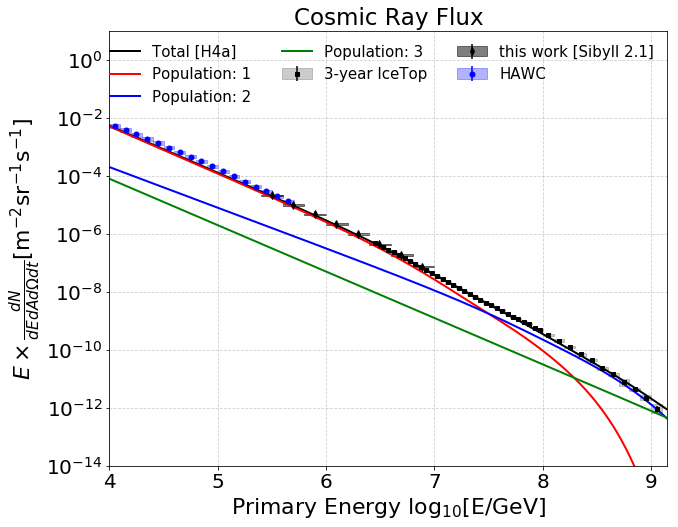

In [27]:
E = numpy.logspace(0,11.5,int(11.5*320)+1) # GSF needs a range from 0 to 11.5

scaling_factor = E**(scale -1)
cycle1 = scaling_factor * H4a('1st', E)
cycle2 = scaling_factor * H4a('2nd', E)
cycle3 = scaling_factor * H4a('3rd', E)
#cycle4 = scaling_factor * H4a('4th', E)
cycleA = scaling_factor * H4a('all', E)

params = {'legend.fontsize': 18,
          'axes.labelsize': 22,
          'axes.titlesize':23,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'figure.figsize':(10, 8),
          'axes.grid':True}
plt.rcParams.update(params)

E = numpy.log10(E)
plt.figure()
# ===== Peter Cycles ==========
f1,=plt.plot(E, cycleA, color='k', lw=2, label='Total [H4a]')
f2,=plt.plot(E, cycle1, color='r', lw=2, label='Population: 1')
f3,=plt.plot(E, cycle2, color='b', lw=2, label='Population: 2')
f4,=plt.plot(E, cycle3, color='g', lw=2, label='Population: 3')
# ====== IceTop Spectrum ===========
f5=plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', markersize=4) # 3-year IceTop                                                                             
for i in range(len(H4a_E)):                                                                                                                                                    
    f5f=plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], 
                     (Flux+Syst_err_high)[i], color='k', alpha=0.2) 
f6=plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', fmt='d', markersize=5) # this work [Sibyll 2.1]
# ========= HAWC =================
scaling_factor_hawc = (10**Hawc_E)**(scale)
HawcFlux           = Hawc_Flux*scaling_factor_hawc
Hawc_stat          = Hawc_err*scaling_factor_hawc
Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
f7=plt.errorbar(Hawc_E, HawcFlux, yerr=Hawc_stat, color='b', fmt='o', markersize=5) # HAWC
for i in range(len(Hawc_E)):                                                                                                                                                    
    f7f=plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

for i in range(int(sum(ene_mask))):
        f6f=plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5) 

plt.yscale('log')
plt.ylim(1e-14, 1e1)
plt.xlim(4,9.15)
plt.legend([f1,f2,f3,f4,(f5,f5f),(f6,f6f),(f7,f7f)], 
           ['Total [H4a]','Population: 1','Population: 2','Population: 3', '3-year IceTop', 'this work [Sibyll 2.1]', 'HAWC'],
            fontsize=15, ncol=3, frameon=False, numpoints=1)
plt.grid(linestyle='--', alpha=0.6)
plt.xlabel(r'Primary Energy log$_{10}$[E/GeV]')
if scale!=1:
    plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rm GeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}sr^{-1}s^{-1}$]')
else:
    plt.ylabel(r'$E\times\frac{dN}{dE dA d\Omega dt}$'+ r'[$\rm m^{-2}sr^{-1}s^{-1}$]')
    
plt.title('Cosmic Ray Flux')
if savefig:
    plt.savefig(rfr_savedir+'CR_flux_with_peter_cycle_h4a_scale%s.png'%str(scale), bbox_inches='tight')

/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in divide
/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


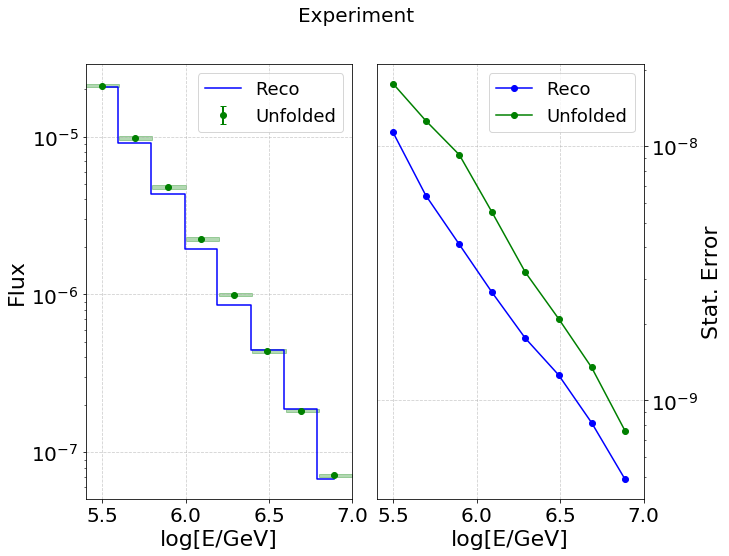

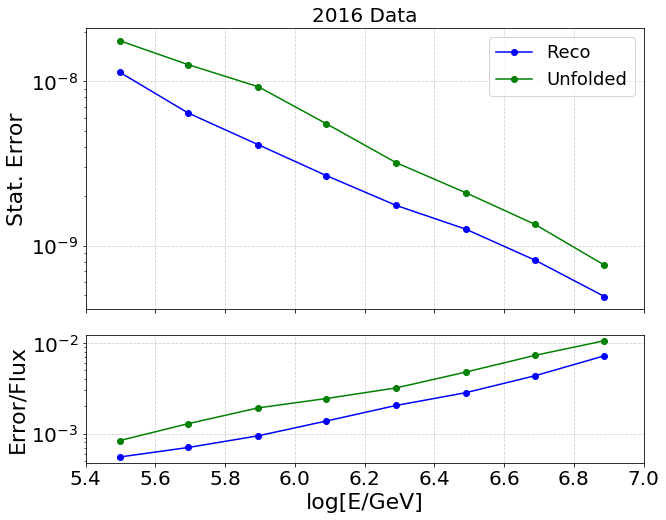

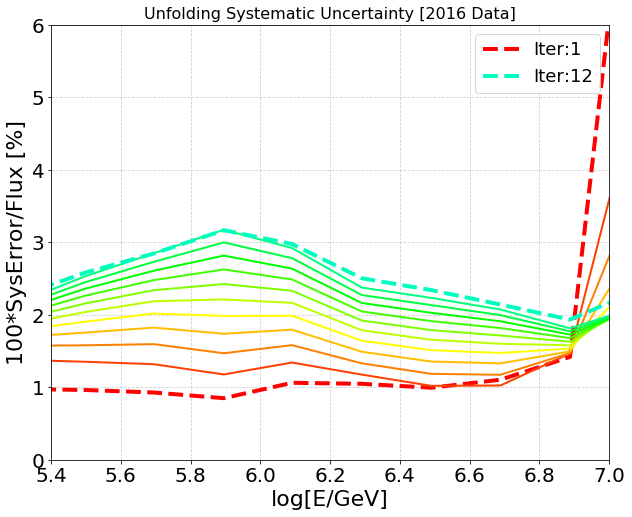

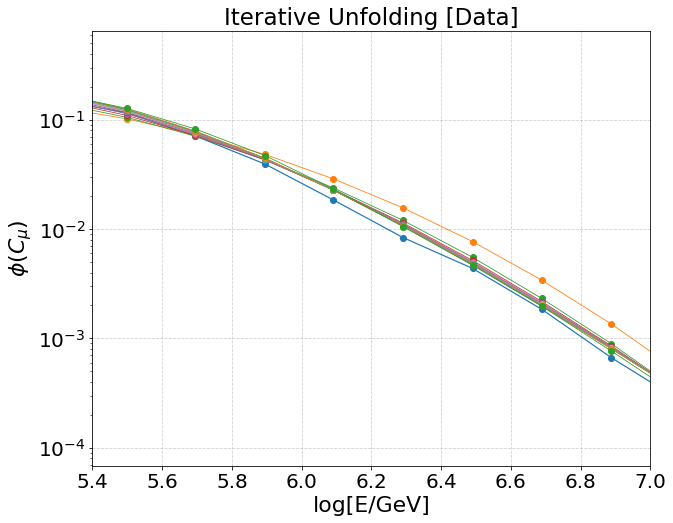

In [28]:
fig = plt.figure()
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[:3, :2])
ax2 = plt.subplot(gs[:3, 2:4])

ax1.step(mid_logE[ene_mask], NEobs_flux[ene_mask], color='b', label='Reco', lw=1.5, where='mid')
ax1.errorbar(mid_logE[ene_mask], expflux[ene_mask], yerr=stat_experr[ene_mask], 
             color='g', label='Unfolded',
             elinewidth=2,
             capsize=3,
             ls='None', marker='.', ms=12, )

ax1.set_yscale('log')
ax1.set_xlabel('log[E/GeV]')
ax1.set_ylabel('Flux')
ax1.set_xticks(numpy.linspace(4.0,7.0,7))
ax1.set_xlim(5.4, 7.0)
ax1.legend()
ax1.grid(linestyle='--', alpha=0.6)
for i in range(int(sum(ene_mask))):                                                                                                                                                    
    ax1.fill_between(STA2_loge[i:i+2], (STA2_flux-sys_experror[ene_mask])[i], 
                     (STA2_flux+sys_experror[ene_mask])[i], color='g', alpha=0.3) 

ax2.plot(mid_logE[ene_mask], NEobs_flux_err[ene_mask], 'bo-', 
         label='Reco', lw=1.5)
ax2.plot(mid_logE[ene_mask], stat_experr[ene_mask], 'go-', 
         label='Unfolded', lw=1.5)
ax2.set_xlabel('log[E/GeV]')
ax2.set_ylabel('Stat. Error')
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")
ax2.set_xticks(numpy.linspace(4.0,7.0,7))
ax2.set_yscale('log')
ax2.set_xlim(5.4, 7.0)
ax2.legend()
ax2.grid(linestyle='--', alpha=0.6)
plt.suptitle('Experiment', fontsize=20)
if savefig:
    figname='unfolding_stat_error_comparison_exp_%s_%s_len%i_%s.png'%(composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')

# --------------------------------------------------------------------
plt.figure()  
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[:2, :])
ax2 = plt.subplot(gs[2, :], sharex=ax1)
ax1.plot(mid_logE[ene_mask], NEobs_flux_err[ene_mask], 'bo-', 
         label='Reco', lw=1.5)
ax1.plot(mid_logE[ene_mask], stat_experr[ene_mask], 'go-', 
         label='Unfolded', lw=1.5)
ax2.plot(mid_logE[ene_mask], (NEobs_flux_err/NEobs_flux)[ene_mask], 'bo-', lw=1.5)
ax2.plot(mid_logE[ene_mask], (stat_experr/expflux)[ene_mask], 'go-', lw=1.5)
ax1.tick_params(labelbottom='off')
ax1.set_ylabel('Stat. Error')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(linestyle='--', alpha=0.6)
ax1.set_title('2016 Data', fontsize=20)
ax2.set_xlabel('log[E/GeV]')
ax2.set_ylabel('Error/Flux')
ax2.set_yscale('log')
ax2.grid(linestyle='--', alpha=0.6)
plt.xlim(5.4, 7.0)
if savefig:
    figname='unfolding_stat_error_only_exp_%s_%s_len%i%s.png'%(composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')

# ------------------------------------------------------------------------------
plt.figure()
import colorsys
HSV = [(x*0.5/maxiter, 1,1) for x in range(maxiter)]
RGB = map(lambda x: colorsys.hsv_to_rgb(*x), HSV)
sys_iteration = 100.*(unfolded_result['sys_err'])/(unfolded_result['unfolded'])
for i in range(maxiter):
    if i==0 or i==(maxiter-1):
        #print (sys_iteration[i])[ene_mask]
        plt.plot(mid_logE, sys_iteration[i], color=RGB[i], 
            label='Iter:%i'%(i+1), lw=4, linestyle='--')
    else:
        plt.plot(mid_logE, sys_iteration[i], color=RGB[i], lw=2)
plt.xlabel('log[E/GeV]')
plt.ylabel('100*SysError/Flux [%]')
plt.title('Unfolding Systematic Uncertainty [2016 Data]', fontsize=16)
plt.legend(loc='best')
plt.xlim(5.4,7.0)
plt.ylim(0,6)
plt.grid(linestyle='--', alpha=0.6)
if savefig:
    figname='unfolding_sys_uncertainty_only_exp_%s_%s_len%i%s.png'%(composition_model,particle,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')
    
if return_iterations:
    plt.figure()
    #plt.plot(mid_logE, prior, label='Prior', marker='o', lw=1.2)
    plt.plot(mid_logE, NEobs_rate, label='Data Reco', marker='o', lw=1.2)
    for i in range(maxiter):
        plt.plot(mid_logE, unfolded_result['unfolded'][i], marker='o', 
                 label='Iter:%i'%(i+1), lw=0.8)
        #print (unfolded_result['unfolded'][i])[ene_mask]
    #plt.legend()
    plt.yscale('log')
    plt.xlim(5.4,7.0)
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel('log[E/GeV]')
    plt.ylabel(r'$\phi(C_\mu)$')
    plt.title('Iterative Unfolding [Data]')
    if savefig:
        figname='unfolding_iteration_spectrum_exp_%s_%s_len%i_%s.png'%(composition_model,particle,lenbins,name)
        plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')

    # ======Unfolding Matrix========
    if plot_unfolding:
        X,Y = numpy.meshgrid(loge_bins, loge_bins)
        for i in range(maxiter):
            if i==(maxiter-1):
                plt.figure(figsize=(5,8))
                plt.pcolormesh(X, Y, unfolded_result['unfolding_matrix'][i], 
                               norm=LogNorm(), cmap='Spectral_r', vmin=1e-7, vmax=1e0)
                plt.xlabel('log[Etrue/GeV]')
                plt.ylabel('log[Ereco/GeV]')
                plt.grid(linestyle='--', alpha=0.6)
                plt.colorbar()
                ax = plt.gca()
                ax.set_xticks(numpy.linspace(4.0,7.0,4))
                plt.title('Unfolding Matrix [Data, %i]'%(i+1))
                if savefig:
                    figname='unfolding_matrix_exp_iter%i_%s_%s_len%i%s.png'%(i,composition_model,particle,lenbins,name)
                    plt.savefig(rfr_savedir+figname, bbox_inches = 'tight')

Note: Systematics for HAWC might not be calculated properly. The one used here is sys_low and sys_high, and it ignores the sys_mc.

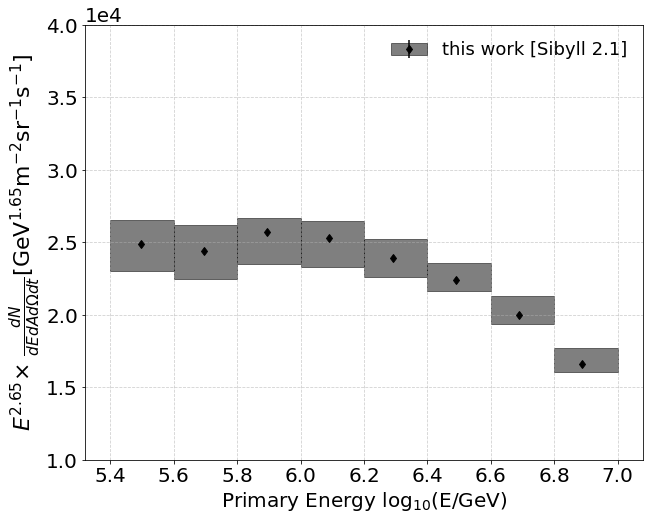

In [29]:
scale = 2.65

scale_factor_exp = scale_factor_func(scaleE_exp, scale)
scale_factor_3yr = scale_factor_func(scaleE_3yr, scale)
# ================== Scale 3yr Spectrum ====================
Flux           = H4a_Flux*scale_factor_3yr
Error_flux     = H4a_Flux_err*scale_factor_3yr
Syst_err_high  = Syst_high*scale_factor_3yr
Syst_err_low   = Syst_low*scale_factor_3yr

# ============== Flux with scaled energy spectrum ===========
if scale_unfolding:
    unfolded_energy_y = numpy.dot(scaledNEobs_rate,unfolding_matrix)

    expflux = cr_flux(unfolded_energy_y,
                   loge_bins=loge_bins,
                   Aeff=Aeff,
                   cos1=cos1, cos2=cos2
                  )
else:
    expflux = scale_factor_exp*expflux
    
stat_experr = scale_factor_exp*stat_experr

# ================ Make Scaled Flux easy to Read ====================
STA2_flux = expflux[ene_mask]
STA2_err  = stat_experr[ene_mask]
STA2_sys_low  = (scale_factor_exp[ene_mask])*STA2_sys_low
STA2_sys_high = (scale_factor_exp[ene_mask])*STA2_sys_high

# ============== Plot Data Scaled Flux after Unfolding ==============
plt.figure()
f1=plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
                fmt='d', markersize=6, label='this work [Sibyll2.1]')
for i in range(int(sum(ene_mask))):
    f1f=plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5)

if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

if plot_h4a:
    model_scaling_factor = scale_factor_func(10**model_bin, scale)
    model_h4a  = (model_scaling_factor*H4a(particle='all', E=10**model_bin))
    plt.plot(model_bin, model_h4a, 'r--', label='H4a', alpha=0.5)

plt.xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)', fontsize=20)
if scale!=1:
    plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{dN}{dE dA d\Omega dt}$'+\
               r'[$\rm GeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}sr^{-1}s^{-1}$]')
else:
    plt.ylabel(r'$E\times\frac{dN}{dE dA d\Omega dt}$'+ r'[$\rm m^{-2}sr^{-1}s^{-1}$]')

#plt.yscale('log')
plt.ylim(5.44,7.0)
plt.ylim(1e4,4e4)
plt.legend([(f1,f1f)], ['this work [Sibyll 2.1]'], loc='best', frameon=False, numpoints=1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid(linestyle='--', alpha=0.6)
if savefig:
    figname='CR_flux_experiment_2016alone_scale%.2f_len%i_%s.png'%(scale,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')

[24883.08378667604, 24385.185378089292, 25680.962877565824, 25315.24502580052, 23951.063186073807, 22433.9770638089, 19994.20115882596, 16576.083191680027]
[20.81278987445362, 31.38264267364959, 49.443804313839166, 61.83610897030078, 76.64627138702333, 107.38221678404089, 146.60263438448834, 176.58557584866207]


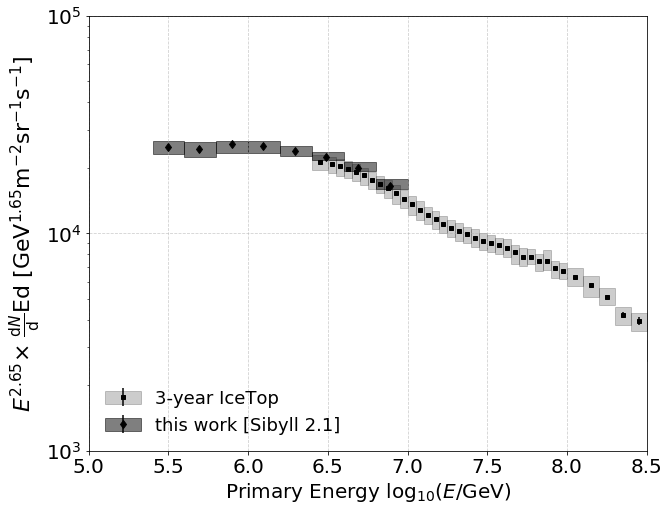

In [30]:
print list(STA2_flux)
print list(STA2_err)

plt.figure()
f1=plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', markersize=4, label='3 yr IT')                                                                                  
for i in range(len(H4a_E)):                                                                                                                                                    
    f1f=plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], (Flux+Syst_err_high)[i], color='k', alpha=0.2) 
f2=plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', 
             fmt='d', markersize=6, label='this work [Sibyll2.1]')
for i in range(int(sum(ene_mask))):
    f2f=plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5) 

if plot_hawc:
    scaling_factor_hawc = (10**Hawc_E)**(scale)
    HawcFlux           = Hawc_Flux*scaling_factor_hawc
    plt.plot(Hawc_E, HawcFlux, 'bo', label='HAWC')
    Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
    Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
    plt.xlim(4.0,8.5)
    for i in range(len(Hawc_E)):                                                                                                                                                    
        plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

if plot_h4a:
    model_scaling_factor = scale_factor_func(10**model_bin, scale)
    model_h4a  = (model_scaling_factor*H4a(particle='all', E=10**model_bin))
    plt.plot(model_bin, model_h4a, 'r--', label='H4a', alpha=0.5)

'''ax = plt.gca()
ax.annotate('',
            xy=(6.6, 1300), xycoords='data',
            xytext=(15, 15*(scale-1)), textcoords='offset points',
            size=10,
            arrowprops=dict(arrowstyle="<-")
           )'''

plt.xlabel('Primary Energy ' +r'log$_{10}$($E$/GeV)', fontsize=20)
plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{{\rm d}N}{\rm d}E \rm d}A \rm d}\Omega \rm d}t}$'+\
               r' [$\rm GeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}sr^{-1}s^{-1}$]',
               fontsize=22)

plt.yscale('log')
plt.legend([(f1,f1f), (f2,f2f)], ['3-year IceTop', 'this work [Sibyll 2.1]'], loc='lower left', frameon=False, numpoints=1)
plt.xlim(5.0,8.5)
plt.ylim(1e3,1e5)
plt.grid(linestyle='--', alpha=0.6)
if savefig:
    figname='CR_flux_experiment_scale%.2f_len%i%s.png'%(scale,lenbins,name)
    plt.savefig(rfr_savedir+figname, bbox_inches='tight')
#plt.savefig(rfr_savedir+'CR_flux_experiment_with_HAWC_scale2.65.png', bbox_inches='tight')
if savehdf:
    hf = tables.open_file('flux_storage_temp%s.h5'%name, 'a')
    namemidE = 'STA2_midE_exp_%s_%s'%(which_scaling,which_prior)
    nameflux = 'STA2_flux_exp_%s_%s_%s'%(which_scaling,which_prior,particle)
    namestat = 'STA2_stat_exp_%s_%s_%s'%(which_scaling,which_prior,particle)
    namesysL = 'STA2_sys_low_exp_%s_%s_%s'%(which_scaling,which_prior,particle)
    namesysH = 'STA2_sys_high_exp_%s_%s_%s'%(which_scaling,which_prior,particle)
    if cos2==0.8:
        nameflux = 'STA2_flux_exp_%s_%s_%s_cos80_90'%(which_scaling,which_prior,particle)
    if namemidE in hf.root:
        hf.remove_node('/', namemidE)
    if nameflux in hf.root:
        hf.remove_node('/', nameflux)
    if namestat in hf.root:
        hf.remove_node('/', namestat)
    if namesysL in hf.root:
        hf.remove_node('/', namesysL)
    if namesysH in hf.root:
        hf.remove_node('/', namesysH)
    hf.create_array('/', namemidE, STA2_midE)
    hf.create_array('/', nameflux, STA2_flux)
    hf.create_array('/', namestat, STA2_err)
    hf.create_array('/', namesysL, STA2_sys_low)
    hf.create_array('/', namesysH, STA2_sys_high)
    hf.close()
    

In [31]:
print list(STA2_flux)
print list(STA2_err)
print list(STA2_sys_low)
print list(STA2_sys_high)
print list(STA2_midE)

[24883.08378667604, 24385.185378089292, 25680.962877565824, 25315.24502580052, 23951.063186073807, 22433.9770638089, 19994.20115882596, 16576.083191680027]
[20.81278987445362, 31.38264267364959, 49.443804313839166, 61.83610897030078, 76.64627138702333, 107.38221678404089, 146.60263438448834, 176.58557584866207]
[1826.679826613584, 1884.1577592108292, 2196.5099551114567, 2011.4451106388292, 1322.9688022074267, 762.7433815741559, 650.529496265234, 526.5029172693379]
[1646.9532847008973, 1824.5641150730146, 1007.8480334292935, 1189.546455577471, 1304.2875650680553, 1117.307175896363, 1298.7035987897052, 1142.8949330535752]
[5.498159292191474, 5.6946563280188665, 5.895515327230461, 6.090917086756846, 6.290695770427586, 6.4901251990200235, 6.6886367022564945, 6.888000499437496]


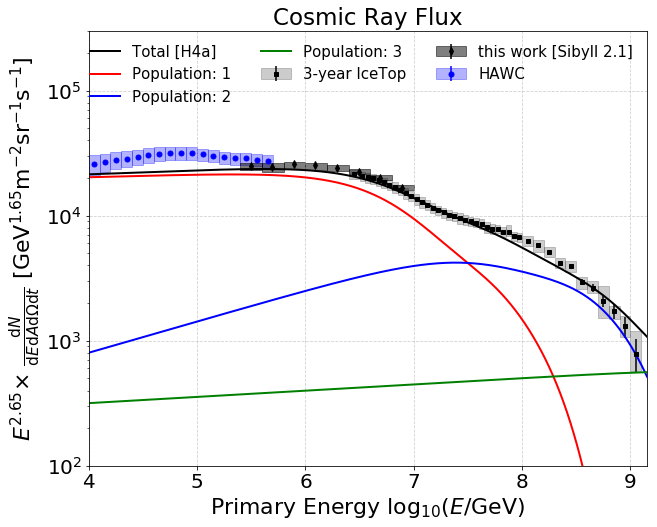

In [32]:
E = numpy.logspace(0,11.5,int(11.5*320)+1) # GSF needs a range from 0 to 11.5

scaling_factor = E**(scale -1)
cycle1 = scaling_factor * H4a('1st', E)
cycle2 = scaling_factor * H4a('2nd', E)
cycle3 = scaling_factor * H4a('3rd', E)
cycleA = scaling_factor * H4a('all', E)

params = {'legend.fontsize': 18,
          'axes.labelsize': 22,
          'axes.titlesize':23,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'figure.figsize':(10, 8),
          'axes.grid':True}
plt.rcParams.update(params)

E = numpy.log10(E)
plt.figure()
# ===== Peter Cycles ==========
f1,=plt.plot(E, cycleA, color='k', lw=2, label='Total [H4a]')
f2,=plt.plot(E, cycle1, color='r', lw=2, label='Population: 1')
f3,=plt.plot(E, cycle2, color='b', lw=2, label='Population: 2')
f4,=plt.plot(E, cycle3, color='g', lw=2, label='Population: 3')
# ====== IceTop Spectrum ===========
f5=plt.errorbar(H4a_E, Flux, yerr=Error_flux, color='k', fmt='s', markersize=4) # 3-year IceTop                                                                             
for i in range(len(H4a_E)):                                                                                                                                                    
    f5f=plt.fill_between(H4a_E_bins[i:i+2], (Flux-Syst_err_low)[i], 
                     (Flux+Syst_err_high)[i], color='k', alpha=0.2) 
f6=plt.errorbar(STA2_midE, STA2_flux, yerr=STA2_err, color='k', fmt='d', markersize=5) # this work [Sibyll 2.1]
# ========= HAWC =================
scaling_factor_hawc = (10**Hawc_E)**(scale)
HawcFlux           = Hawc_Flux*scaling_factor_hawc
Hawc_stat          = Hawc_err*scaling_factor_hawc
Hawc_sysL          = Hawc_sysl*scaling_factor_hawc
Hawc_sysH          = Hawc_sysh*scaling_factor_hawc
f7=plt.errorbar(Hawc_E, HawcFlux, yerr=Hawc_stat, color='b', fmt='o', markersize=5) # HAWC
for i in range(len(Hawc_E)):                                                                                                                                                    
    f7f=plt.fill_between(Hawc_E_bins[i:i+2], (HawcFlux-Hawc_sysL)[i], (HawcFlux+Hawc_sysL)[i], color='b', alpha=0.3) 

for i in range(int(sum(ene_mask))):
        f6f=plt.fill_between(STA2_loge[i:i+2], (STA2_flux-STA2_sys_low)[i], 
                         (STA2_flux+STA2_sys_high)[i], color='k', alpha=0.5) 

plt.yscale('log')
plt.ylim(1e2,3e5)
plt.xlim(4,9.15)
plt.legend([f1,f2,f3,f4,(f5,f5f),(f6,f6f),(f7,f7f)], 
           ['Total [H4a]','Population: 1','Population: 2','Population: 3', '3-year IceTop', 'this work [Sibyll 2.1]', 'HAWC'],
            fontsize=15, ncol=3, frameon=False, numpoints=1)
plt.xlabel(r'Primary Energy log$_{10}$($E/{\rm GeV}$)')
plt.ylabel(r'$E^{'+str(scale)+'}$'+r'$\times$ $\frac{{\rm d}N}{{\rm d}E {\rm d}A {\rm d}\Omega {\rm d}t}$'+\
               r' [$\rm GeV^{'+str(scale-1)+'}$' +r'$\rm m^{-2}sr^{-1}s^{-1}$]')
plt.grid(linestyle='--', alpha=0.6)
plt.title('Cosmic Ray Flux')
if savefig:
    plt.savefig(rfr_savedir+'CR_flux_with_peter_cycle_h4a_scale%s.png'%str(scale), bbox_inches='tight')

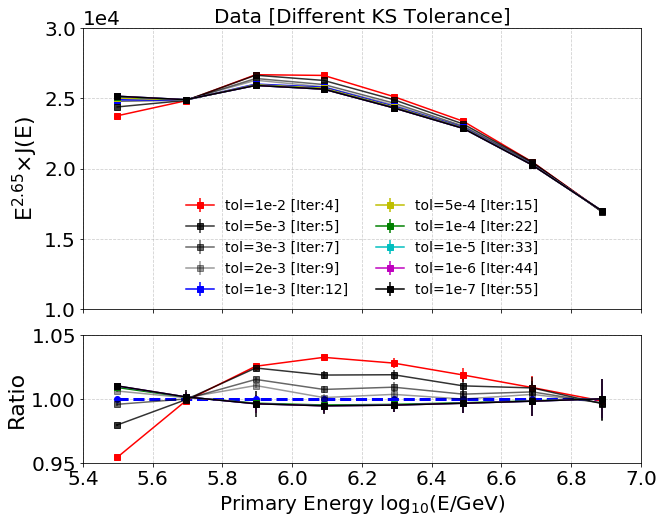

In [33]:
# smooth=1e-3, degree=3
# number of iteration = 4, tolerance=1e-2
#f2 = numpy.array([25136.367976248381, 26006.155977418599, 28167.675101045068, 27908.120404306945, 26535.883810754945, 24645.557001439858, 21731.147855854353, 17715.301971407938])
# number of iteration = 12, tolerance=1e-3
#f3 = numpy.array([26565.933001944231, 26086.627059014831, 27402.66276874538, 26950.260209212483, 25750.987164188966, 24141.878857671949, 21513.736883297723, 17744.27506156341])
# number of iteration = 15, tolerance=5e-4
#ft = numpy.array([26774.548070382978, 26119.815023367155, 27325.892231728561, 26842.756611088345, 25658.887610001646, 24079.728058425251, 21483.975465233038, 17744.089829755463])
# number of iteration = 24, tolerance=1e-4
#f4 = numpy.array([26919.624124021982, 26144.678094616393, 27275.505093100397, 26770.864585622738, 25596.89353896397, 24037.602184250551, 21463.568560125841, 17743.682535836284])
# number of iteration = 37, tolerance=1e-5
#f5 = numpy.array([26958.457087000577, 26151.564645278802, 27262.407930527381, 26751.995201441085, 25580.568136157814, 24026.470118431505, 21458.145059669998, 17743.5379655082])
# number of iteration = 49, tolerance=1e-6
#f6 = numpy.array([26961.921458180645, 26152.183604715177, 27261.247260399512, 26750.319274071815, 25579.117070778273, 24025.479877912752, 21457.662001514978, 17743.52436718735])
# number of iteration = 62, tolerance=1e-7
#f7 = numpy.array([26962.30933620569, 26152.252951191495, 27261.117387944163, 26750.131709308367, 25578.954660846717, 24025.369037714561, 21457.607925305249, 17743.522837608012])

# number of iteration = 4, tolerance=1e-2
f2 = numpy.array([23753.506537952238, 24822.129367094316, 26673.712021106006, 26624.440167396737, 25122.560719725192, 23364.476140844614, 20465.854896783829, 16980.071084966501])
e2 = numpy.array([12.98299156562716, 17.921521423712228, 26.595610797927652, 37.310843412335629, 50.336437905751346, 71.12767865864717, 99.672108822611079, 133.15594518427386])
# number of iteration=5, tolerance=5e-3
f3a= numpy.array([24384.222372351418, 24845.790690909907, 26637.977000207418, 26267.399863183229, 24899.842062251948, 23169.871811322177, 20459.93363654588, 16944.150330208442])
e3a= numpy.array([14.645370471198982, 20.055743159968038, 30.099699620980637, 41.087686881359026, 54.925754731189024, 76.996715594218998, 108.19078221963338, 142.30153759361107])
# number of iteration=7, tolerance=3e-3
f3b= numpy.array([24786.327151589056, 24860.663376002682, 26406.061845772369, 25977.308683009433, 24661.983487710611, 23021.365784330086, 20397.099447121207, 16953.21188036296])
e3b= numpy.array([16.960046273845329, 23.84464266370167, 36.230541435124842, 47.902908722622847, 62.593861170257817, 87.082796603814941, 121.37569268447045, 156.02828320103194])
# number of iteration=9, tolerance=2e-3
f3c= numpy.array([25045.429877640261, 24885.536847763768, 26281.389947674001, 25813.511979300405, 24524.796623865353, 22933.540616496404, 20357.670660429834, 16955.565878110265])
e3c= numpy.array([18.807368663320169, 27.26866664575628, 41.860913612086037, 53.88802825724084, 68.879905005888631, 95.37991271207234, 131.72900910473865, 165.5523956254689])
# number of iteration=12, tolerance=1e-3
f3 = numpy.array([24893.040014332961, 24863.129307434403, 26010.768772984, 25787.683279394267, 24439.158908216552, 22937.132465946521, 20286.798635597039, 17007.554246755004])
e3 = numpy.array([20.846891016863111, 31.846017035360269, 49.558535173556265, 62.242330882033833, 76.656512081717352, 105.85061297909984, 143.52690922560652, 175.60137028181305])
# number of iteration=15, tolerance=5e-4
ft = numpy.array([25010.971145005176, 24880.153493694575, 25962.761643438036, 25720.612010484219, 24382.059309850712, 22899.707402314791, 20269.380465723811, 17007.680134309037])
et = numpy.array([22.879003732982284, 36.044942158676228, 57.511452506236438, 69.692375218878396, 82.824748814894434, 113.87333606286826, 152.58904584524407, 181.54564970107782])
# number of iteration=22, tolerance=1e-4
f4 = numpy.array([25114.052592508448, 24896.096033726371, 25922.577169194446, 25663.724410356848, 24333.398886331877, 22867.650980381557, 20254.323188626557, 17007.618694033608])
e4 = numpy.array([26.979581659062216, 45.465937585324269, 77.900609229967529, 85.589591405409749, 93.040297052293454, 126.58448783659557, 165.88225563478184, 188.0404638062378])
# number of iteration=33, tolerance=1e-5
f5 = numpy.array([25142.021120133599, 24900.582976393896, 25911.944703799087, 25648.554617900485, 24320.387162103223, 22859.05394877911, 20250.263962712677, 17007.576356259378])
e5 = numpy.array([32.360290938833501, 62.923553031419125, 119.02156015640574, 108.58530406502599, 101.93028919023727, 136.46789851799852, 174.82006066337368, 190.54137623679577])
# number of iteration=44, tolerance=1e-6
f6 = numpy.array([25144.857245593841, 24901.041703065581, 25910.872791967435, 25647.022486100213, 24319.072153183046, 22858.184514231551, 20249.85295453771, 17007.571473841635])
e6 = numpy.array([37.011803745616866, 87.112487803272487, 176.44655210402667, 130.65143915907922, 106.42397047601587, 140.73851893197275, 178.05869446236025, 190.93766098634501])
# number of iteration=55, tolerance=1e-7
# L7 and H7 is the total systematic uncertainty in flux when tolerance=1e-7
L7 = numpy.array([2295.6887910385622, 3392.955982594719, 4271.7110209651337, 3462.0479533205162, 1890.9729149200471, 1012.0130944527949, 748.24403184660719, 489.87688264783776])
H7 = numpy.array([2146.6441731439595, 3339.1897549143905, 3794.1881473372273, 3037.3884074902585, 1918.8921405681097, 1331.7470112831456, 1290.1581756058554, 1066.1372809941474])
f7 = numpy.array([25145.145317050279, 24901.088335117307, 25910.763979648873, 25646.866927065446, 24318.93863025785, 22858.096227837952, 20249.811213844587, 17007.570971906131])
e7 = numpy.array([41.276227418642733, 120.87931535924156, 258.54834807518961, 152.57000866648107, 108.87374008888236, 142.78132755503876, 179.42266088527438, 191.00472734725116])
 
teb = numpy.array([ 5.49811971,  5.69467844,  5.89531019,  6.09042669,  
                     6.29077748 , 6.49052739 ,  6.68873398,  6.88745929])

# ===============================================================
plt.figure()  
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[:2, :])
ax2 = plt.subplot(gs[2, :], sharex=ax1)
ax1.errorbar(teb, f2, yerr=e2, color='r', fmt='s', ls='-', lw=1.5, label='tol=1e-2 [Iter:4]')
ax1.errorbar(teb, f3a, yerr=e3a, color='k', fmt='s', ls='-', lw=1.5, label='tol=5e-3 [Iter:5]', alpha=0.8)
ax1.errorbar(teb, f3b, yerr=e3b, color='k', fmt='s', ls='-', lw=1.5, label='tol=3e-3 [Iter:7]', alpha=0.6)
ax1.errorbar(teb, f3c, yerr=e3c, color='k', fmt='s', ls='-', lw=1.5, label='tol=2e-3 [Iter:9]', alpha=0.4)
ax1.errorbar(teb, f3, yerr=e3, color='b', fmt='s', ls='-', lw=1.5, label='tol=1e-3 [Iter:12]')
ax1.errorbar(teb, ft, yerr=et, color='y', fmt='s', ls='-', lw=1.5, label='tol=5e-4 [Iter:15]')
ax1.errorbar(teb, f4, yerr=e4, color='g', fmt='s', ls='-', lw=1.5, label='tol=1e-4 [Iter:22]')
ax1.errorbar(teb, f5, yerr=e5, color='c', fmt='s', ls='-', lw=1.5, label='tol=1e-5 [Iter:33]')
ax1.errorbar(teb, f6, yerr=e6, color='m', fmt='s', ls='-', lw=1.5, label='tol=1e-6 [Iter:44]')
ax1.errorbar(teb, f7, yerr=e7, color='k', fmt='s', ls='-', lw=1.5, label='tol=1e-7 [Iter:55]')
ax2.errorbar(teb, (f2/f3), yerr=errorXbyY(f2,f3,e2,e3), color='r', fmt='s', ls='-', lw=1.5)
ax2.errorbar(teb, (f3a/f3), yerr=errorXbyY(f3a,f3,e3a,e3), color='k', alpha=0.8, fmt='s', ls='-', lw=1.5)
ax2.errorbar(teb, (f3b/f3), yerr=errorXbyY(f3b,f3,e3a,e3), color='k', alpha=0.6, fmt='s', ls='-', lw=1.5)
ax2.errorbar(teb, (f3c/f3), yerr=errorXbyY(f3c,f3,e3a,e3), color='k', alpha=0.4, fmt='s', ls='-', lw=1.5)
ax2.plot(teb, (f3/f3), 'bo--', lw=3)
ax2.errorbar(teb, (f4/f3), yerr=errorXbyY(f4,f3,e4,e3), color='g', fmt='s', ls='-', lw=1.5)
ax2.errorbar(teb, (f5/f3), yerr=errorXbyY(f5,f3,e5,e3), color='c', fmt='s', ls='-', lw=1.5)
ax2.errorbar(teb, (f6/f3), yerr=errorXbyY(f6,f3,e6,e3), color='m', fmt='s', ls='-', lw=1.5)
ax2.errorbar(teb, (f7/f3), yerr=errorXbyY(f7,f3,e7,e3), color='k', fmt='s', ls='-', lw=1.5)

'''ax2.plot(teb, (f2/f3), 'ro-', lw=1.5)
ax2.plot(teb, (f3/f3), 'bo--', lw=3)
ax2.plot(teb, (ft/f3), 'yo-', lw=1.5)
ax2.plot(teb, (f4/f3), 'go-', lw=1.5)
ax2.plot(teb, (f5/f3), 'co-', lw=1.5)
ax2.plot(teb, (f6/f3), 'mo-', lw=1.5)
ax2.plot(teb, (f7/f3), 'ko-', lw=1.5)'''
ax1.tick_params(labelbottom='off')
ax1.set_ylabel(r'E$^{'+str(scale)+'}$'+r'$\times$J(E)', fontsize=22)
'''legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r',
                         label='Color Patch')]'''

from matplotlib.lines import Line2D
ax1.legend(loc='lower center', fontsize=14, frameon=False, ncol=2)
ax1.set_title('Data [Different KS Tolerance]', fontsize=20)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_ylim(1e4, 3e4)
ax1.grid(linestyle='--', alpha=0.6)
ax2.set_ylabel('Ratio')
ax2.set_xlabel('Primary Energy ' +r'log$_{10}$(E/GeV)', fontsize=20)
ax2.set_ylim(0.95,1.05)
ax2.grid(linestyle='--', alpha=0.6)
plt.xlim(5.4, 7.0)
if savefig:
    fn='unfolded_flux_various_KS_tolerance_%s_%s%s.png'%(composition_model,particle,name)
    plt.savefig(rfr_savedir+fn, bbox_inches='tight')

    

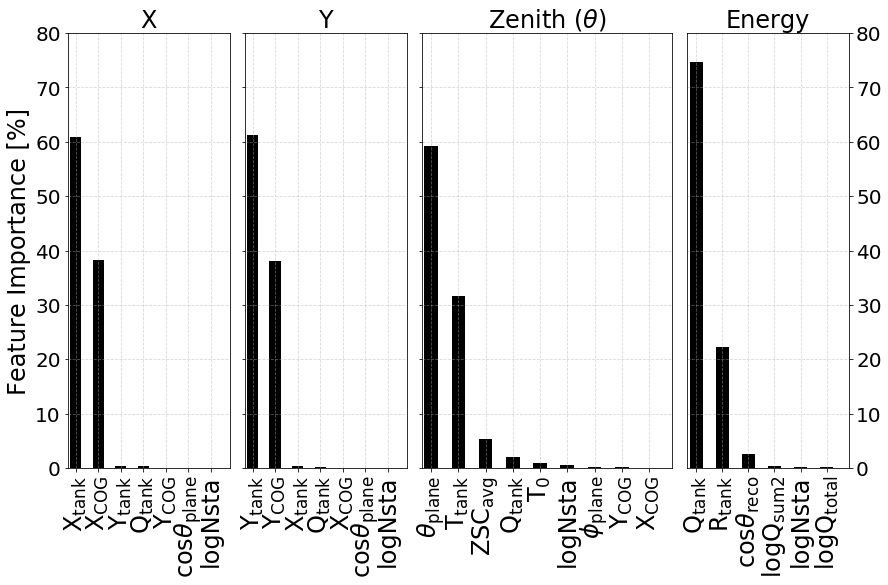

In [34]:
# Originally done in analysis_ML_v1.ipynb

fi_x        = numpy.array([60.9045932704, 38.3289783945, 0.366487535335, 0.294502043176, 
                           0.0768654636897, 0.0189323254986, 0.00964096731534])                        
#fi_x_name   = numpy.array(['hitX', 'cogX', 'hitY', 'hitQ', 'cogY', r'cos$\theta$', 'lNsta'])
fi_x_name   = numpy.array([r'X$_{\rm tank}$', r'X$_{\rm COG}$', r'Y$_{\rm tank}$', r'Q$_{\rm tank}$', r'Y$_{\rm COG}$', 
                           r'cos$\theta_{\rm plane}$', 'logNsta'])

fi_y        = numpy.array([61.238634651, 38.0455369139, 0.407678564506, 0.221103107898, 
                           0.0672441936479, 0.0143645385081, 0.00543803047109])
fi_y_name   = numpy.array([r'Y$_{\rm tank}$', r'Y$_{\rm COG}$', r'X$_{\rm tank}$', r'Q$_{\rm tank}$', r'X$_{\rm COG}$', 
                           r'cos$\theta_{\rm plane}$', 'logNsta'])

fi_zen      = numpy.array([59.2895602802, 31.6706169505, 5.3232019695, 2.10345401001, 
                           0.845769315475, 0.494345783933, 0.10400751176, 0.102350258813, 
                           0.0666939197865])
fi_zen_name = numpy.array([r'$\theta_{\rm plane}$', r'T$_{\rm tank}$', r'ZSC$_{\rm avg}$', r'Q$_{\rm tank}$', r'T$_0$', 
                           'logNsta', r'$\phi_{\rm plane}$', r'Y$_{\rm COG}$', r'X$_{\rm COG}$'])

#fi_ene      = numpy.array([57.844349, 38.864484, 2.712269, 0.392856, 0.094848, 0.091195])
#fi_ene      = numpy.array([57.5951, 39.1592, 2.6627, 0.3800, 0.1089, 0.09419]) #wrong H4a
# Feature importance values are stored in analysis_simulation_HLCCoreSeed_slcQcut_fracradius_final.h5
#   after running "python sklearn_predict_energy.py --savemodel --isMC --savehdf --do predict -f analysis_simulation_HLCCoreSeed_slcQcut_fracradius_final.h5"
fi_ene      = numpy.array([74.655771, 22.16972, 2.612682, 0.34292, 0.12437, 0.094537]) #H4aOrig
fi_ene_name = numpy.array([r'Q$_{\rm tank}$', r'R$_{\rm tank}$', r'cos$\theta_{\rm reco}$', r'logQ$_{\rm sum2}$', 
                           'logNsta', r'logQ$_{\rm total}$'])

fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(3, 9)
ax1 = plt.subplot(gs[:3, :2])
ax2 = plt.subplot(gs[:3, 2:4])
ax3 = plt.subplot(gs[:3, 4:7])
ax4 = plt.subplot(gs[:3, 7:])

# X
x = numpy.arange(len(fi_x))
ax1.set_xticks(x+0.25)
ax1.set_xticklabels(fi_x_name, rotation=90, fontsize=24)
ax1.bar(x+0.25, fi_x, width=0.5, color='k')
ax1.set_ylabel('Feature Importance [%]', fontsize=24)
ax1.set_xlim(-0.1, len(fi_x_name)+.1)
ax1.set_ylim(0, 80)
ax1.set_title('X', fontsize=24)
ax1.grid(linestyle='--', alpha=0.5)

# Y
ax2.set_xticks(x+0.25)
ax2.set_xticklabels(fi_y_name, rotation=90, fontsize=24)
ax2.bar(x+0.25, fi_y, width=0.5, color='k')
ax2.set_xlim(-0.1, len(fi_y_name)+.1)
ax2.set_ylim(0, 80)
ax2.set_yticklabels([])
ax2.set_title('Y', fontsize=24)
ax2.grid(linestyle='--', alpha=0.5)

# zenith
x = numpy.arange(len(fi_zen))
ax3.set_xticks(x+0.25)
ax3.set_xticklabels(fi_zen_name, rotation=90, fontsize=24)
ax3.bar(x+0.25, fi_zen, width=0.5, color='k')
ax3.set_xlim(-0.1, len(fi_zen)+.1)
ax3.set_ylim(0, 80)
ax3.set_yticklabels([])
ax3.set_title(r'Zenith ($\theta$)', fontsize=24)
ax3.grid(linestyle='--', alpha=0.5)

# Energy
x = numpy.arange(len(fi_ene))
ax4.set_xticks(x+0.25)
ax4.set_xticklabels(fi_ene_name, rotation=90, fontsize=24)
ax4.bar(x+0.25, fi_ene, width=0.5, color='k')
ax4.set_xlim(-0.1, len(fi_ene)+.1)
ax4.set_ylim(0, 80)
ax4.yaxis.set_label_position("right")
ax4.yaxis.set_ticks_position("right")
ax4.set_title('Energy', fontsize=24)
ax4.grid(linestyle='--', alpha=0.5)
#plt.suptitle(r"Energy", fontsize=20)
if True:
#if savefig:
    plt.savefig(rfr_savedir+'feature_importance_x_y_zen_energy.png', bbox_inches='tight')
    


In [35]:
tank_positions = {1: {'A': [-265.5299987792969, -497.8949890136719],
          'B': [-255.6999969482422, -496.07000732421875]},
         2: {'A': [-140.36000061035156, -477.76499938964844],
          'B': [-130.63500213623047, -476.5749969482422]},
         3: {'A': [-27.72000026702881, -464.49000549316406],
          'B': [-20.394999504089355, -458.9750061035156]},
         4: {'A': [105.65499877929688, -438.7050018310547],
          'B': [115.26499938964844, -436.864990234375]},
         5: {'A': [214.73999786376953, -432.4100036621094],
          'B': [219.90499877929688, -424.68499755859375]},
         6: {'A': [356.6000061035156, -398.1300048828125],
          'B': [366.2149963378906, -398.3800048828125]},
         7: {'A': [-344.0500030517578, -400.4750061035156],
          'B': [-334.3249969482422, -399.0050048828125]},
         8: {'A': [-231.2249984741211, -389.260009765625],
          'B': [-224.18500518798828, -382.94500732421875]},
         9: {'A': [-85.19499969482422, -359.7300109863281],
          'B': [-76.06499862670898, -362.44000244140625]},
         10: {'A': [25.09500026702881, -342.4700012207031],
          'B': [34.52499961853027, -339.7449951171875]},
         11: {'A': [135.54000091552734, -353.385009765625],
          'B': [134.22000122070312, -343.47999572753906]},
         12: {'A': [279.114990234375, -300.4600067138672],
          'B': [288.75999450683594, -301.50999450683594]},
         13: {'A': [386.1050109863281, -290.32000732421875],
          'B': [393.4499969482422, -283.77000427246094]},
         14: {'A': [-390.0349884033203, -335.68499755859375],
          'B': [-395.4250030517578, -343.8999938964844]},
         15: {'A': [-265.69500732421875, -305.0],
          'B': [-266.8699951171875, -314.8000030517578]},
         16: {'A': [-182.25, -268.1199951171875],
          'B': [-173.01499938964844, -263.8399963378906]},
         17: {'A': [-40.35499954223633, -243.04500579833984],
          'B': [-30.989999771118164, -246.06999969482422]},
         18: {'A': [66.38000106811523, -227.1699981689453],
          'B': [75.67999649047852, -223.73500061035156]},
         19: {'A': [210.22999572753906, -185.0999984741211],
          'B': [220.04000091552734, -186.24500274658203]},
         20: {'A': [311.4750061035156, -228.47000122070312],
          'B': [305.2749938964844, -220.85999298095703]},
         21: {'A': [441.7050018310547, -212.6750030517578],
          'B': [432.9649963378906, -207.02499389648438]},
         22: {'A': [-468.95001220703125, -238.43499755859375],
          'B': [-474.2099914550781, -246.7699966430664]},
         23: {'A': [-388.9750061035156, -194.84000396728516],
          'B': [-381.31500244140625, -188.66000366210938]},
         24: {'A': [-225.47000122070312, -175.76000213623047],
          'B': [-221.37000274658203, -184.4800033569336]},
         25: {'A': [-102.53499984741211, -155.80500030517578],
          'B': [-98.30500030517578, -164.68500518798828]},
         26: {'A': [13.460000038146973, -129.35499572753906],
          'B': [20.950000762939453, -135.9149932861328]},
         27: {'A': [125.58499908447266, -106.19500350952148],
          'B': [134.95999908447266, -108.70999908447266]},
         28: {'A': [228.75, -95.84000015258789],
          'B': [236.12999725341797, -89.84000015258789]},
         29: {'A': [363.385009765625, -115.68500137329102],
          'B': [354.7449951171875, -110.06000137329102]},
         30: {'A': [523.6900024414062, -67.34500122070312],
          'B': [518.1400146484375, -76.07500076293945]},
         31: {'A': [-547.9249877929688, -141.43499755859375],
          'B': [-553.510009765625, -149.5]},
         32: {'A': [-452.6199951171875, -88.37999725341797],
          'B': [-442.77500915527344, -88.6150016784668]},
         33: {'A': [-304.55999755859375, -78.4900016784668],
          'B': [-300.55999755859375, -87.37000274658203]},
         34: {'A': [-181.05500030517578, -58.75],
          'B': [-176.3699951171875, -68.21500015258789]},
         35: {'A': [-86.4000015258789, -30.985000610351562],
          'B': [-76.4900016784668, -29.475000381469727]},
         36: {'A': [37.435001373291016, -57.36000061035156],
          'B': [29.18000030517578, -52.80500030517578]},
         37: {'A': [150.77000427246094, -31.0649995803833],
          'B': [145.34500122070312, -22.655000686645508]},
         38: {'A': [316.0350036621094, -3.805000066757202],
          'B': [311.0749969482422, -12.414999961853027]},
         39: {'A': [434.9700012207031, 3.940000057220459],
          'B': [429.56500244140625, -4.5849997997283936]},
         40: {'A': [530.6050109863281, 20.969999313354492],
          'B': [522.0249938964844, 25.59000015258789]},
         41: {'A': [-506.7899932861328, -0.8450000286102295],
          'B': [-502.2250061035156, -9.755000114440918]},
         42: {'A': [-383.5399932861328, 18.315000534057617],
          'B': [-379.10499572753906, 9.704999923706055]},
         43: {'A': [-260.27000427246094, 38.61000061035156],
          'B': [-255.7800064086914, 29.114999771118164]},
         44: {'A': [-131.47000122070312, 38.26499938964844],
          'B': [-134.97000122070312, 29.4350004196167]},
         45: {'A': [-43.14999961853027, 40.46500015258789],
          'B': [-51.1299991607666, 46.255001068115234]},
         46: {'A': [71.3499984741211, 66.82499694824219],
          'B': [67.07500076293945, 75.39500045776367]},
         47: {'A': [172.68000030517578, 114.55500030517578],
          'B': [170.2750015258789, 124.2249984741211]},
         48: {'A': [365.4499969482422, 151.48500061035156],
          'B': [357.0449981689453, 156.81999969482422]},
         49: {'A': [495.2200012207031, 136.94000244140625],
          'B': [496.76499938964844, 127.48500061035156]},
         50: {'A': [604.1549987792969, 147.50999450683594],
          'B': [596.7449951171875, 140.6050033569336]},
         51: {'A': [-456.8450012207031, 101.56500244140625],
          'B': [-458.26499938964844, 91.2249984741211]},
         52: {'A': [-333.239990234375, 120.63999938964844],
          'B': [-334.51499938964844, 111.43000030517578]},
         53: {'A': [-210.09500122070312, 138.9499969482422],
          'B': [-212.11499786376953, 129.81499481201172]},
         54: {'A': [-121.7599983215332, 136.53500366210938],
          'B': [-129.40499877929688, 142.47000122070312]},
         55: {'A': [21.235000610351562, 155.66500091552734],
          'B': [11.3100004196167, 153.7249984741211]},
         56: {'A': [133.06500244140625, 174.70999908447266],
          'B': [123.9900016784668, 177.21500396728516]},
         57: {'A': [248.7449951171875, 194.55999755859375],
          'B': [241.1999969482422, 200.65499877929688]},
         58: {'A': [400.48500061035156, 220.52499389648438],
          'B': [392.9199981689453, 215.27999877929688]},
         59: {'A': [525.2449951171875, 241.56499481201172],
          'B': [517.6300048828125, 235.4199981689453]},
         60: {'A': [-416.14500427246094, 231.43499755859375],
          'B': [-412.50498962402344, 222.2899932861328]},
         61: {'A': [-288.72999572753906, 232.7300033569336],
          'B': [-292.4250030517578, 224.0]},
         62: {'A': [-201.68999481201172, 234.9800033569336],
          'B': [-209.19499969482422, 241.20499420166016]},
         63: {'A': [-53.35500144958496, 255.73500061035156],
          'B': [-61.53499984741211, 252.5500030517578]},
         64: {'A': [64.76499938964844, 272.45001220703125],
          'B': [55.30999946594238, 271.0449981689453]},
         65: {'A': [153.6050033569336, 302.9650115966797],
          'B': [152.34500122070312, 312.2550048828125]},
         66: {'A': [319.9449920654297, 316.94500732421875],
          'B': [312.5800018310547, 312.5350036621094]},
         67: {'A': [440.3050079345703, 333.4150085449219],
          'B': [431.0349884033203, 330.5749969482422]},
         68: {'A': [-403.48500061035156, 312.2050018310547],
          'B': [-410.86500549316406, 317.40501403808594]},
         69: {'A': [-279.64500427246094, 331.15501403808594],
          'B': [-287.27500915527344, 336.4550018310547]},
         70: {'A': [-161.46499633789062, 354.4250030517578],
          'B': [-167.69499969482422, 361.5950012207031]},
         71: {'A': [-12.585000038146973, 370.239990234375],
          'B': [-21.90999984741211, 367.55999755859375]},
         72: {'A': [123.5150032043457, 400.9149932861328],
          'B': [116.6500015258789, 393.50999450683594]},
         73: {'A': [207.94499969482422, 413.01499938964844],
          'B': [202.02999877929688, 421.2949981689453]},
         74: {'A': [369.3199920654297, 431.0],
          'B': [362.0900115966797, 425.4100036621094]},
         75: {'A': [-352.60499572753906, 421.4250030517578],
          'B': [-361.2449951171875, 424.1700134277344]},
         76: {'A': [-241.86000061035156, 453.32000732421875],
          'B': [-247.61000061035156, 461.43499755859375]},
         77: {'A': [-87.70499801635742, 468.72499084472656],
          'B': [-97.10000228881836, 465.1949920654297]},
         78: {'A': [2.10999995470047, 494.6199951171875],
          'B': [-2.0199999809265137, 503.5950012207031]},
         79: {'A': [18.09999942779541, -94.63000106811523],
          'B': [10.880000114440918, -87.69499969482422]},
         80: {'A': [76.42499923706055, -42.47999954223633],
          'B': [85.64500045776367, -46.0]},
         81: {'A': [77.40999984741211, 37.6150016784668],
          'B': [87.19000244140625, 39.84000015258789]}}

XA = numpy.array([tank_positions[station]['A'][0] for station in range(1,82)])
YA = numpy.array([tank_positions[station]['A'][1] for station in range(1,82)]) 
XB = numpy.array([tank_positions[station]['B'][0] for station in range(1,82)])
YB = numpy.array([tank_positions[station]['B'][1] for station in range(1,82)])


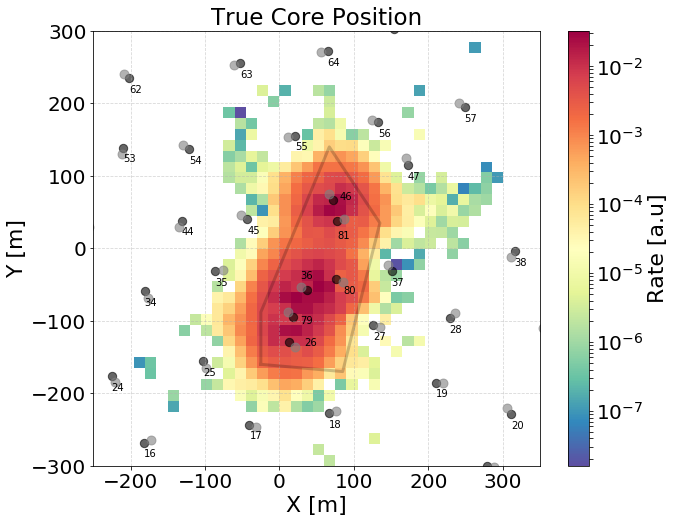

In [36]:
pos_bins = numpy.linspace(-300,300,41)
plt.figure(figsize=(10,8))
plt.scatter(XA, YA, color='k', s=70, alpha=0.6)
plt.scatter(XB, YB, color='gray', s=80, alpha=0.6)
for i in range(81):
    #if i+1 not in [26, 36, 46, 79, 80, 81]:
    if i+1 in [26]:
        plt.text(XA[i]+20, YA[i]-5, i+1, fontsize=10)
    elif i+1 in [79]:
        plt.text(XA[i]+10, YA[i]-10, i+1, fontsize=10)
    elif i+1 in [46]:
        plt.text(XA[i]+10, YA[i], i+1, fontsize=10)
    elif i+1 in [80]:
        plt.text(XA[i]+10, YA[i]-20, i+1, fontsize=10)
    elif i+1 in [81]:
        plt.text(XA[i], YA[i]-25, i+1, fontsize=10)
    elif i+1 in [36]:
        plt.text(XA[i]-10, YA[i]+15, i+1, fontsize=10)
    elif XA[i]<320. and XA[i]>-250. and abs(YA[i])<300.:
        plt.text(XA[i], YA[i]-20, i+1, fontsize=10)

ka = numpy.array([-25, -25,  67, 135., 85., -25])
kha = numpy.array([-160, -88, 140, 35., -170., -160])
plt.plot(ka, kha, 'k', label='Infill Boundary', linewidth=3, alpha=0.2)
abc=plt.hist2d(Tcorex, Tcorey, bins=[pos_bins,pos_bins], weights=Weight, norm=LogNorm(), cmap='Spectral_r')
plt.grid(ls='--', alpha=0.5)
plt.colorbar(label='Rate [a.u]')
plt.xlim(-250,350)
plt.ylim(-300,300)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('True Core Position')
plt.savefig(savedir)
#if savefig:
if True:
    plt.savefig(rfr_savedir+'core_position_true.png', bbox_inches='tight')

Text(0.5,1,'IceTop Geometry')

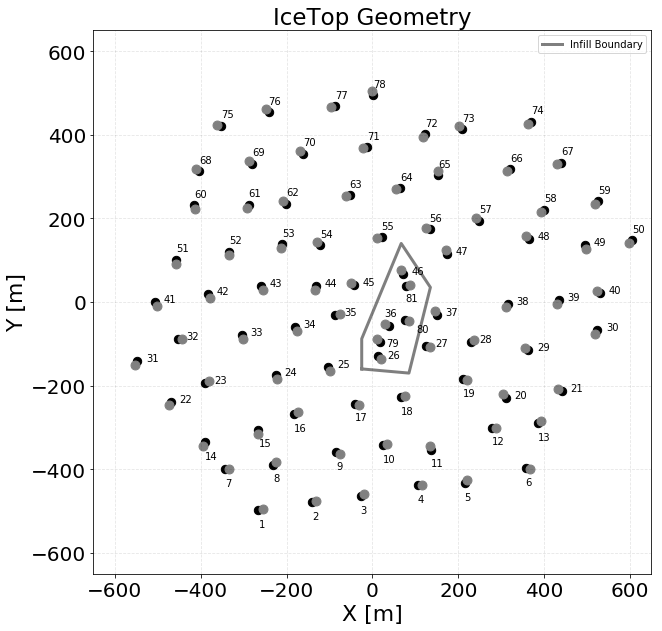

In [37]:
# Plot IceTop Geometry which will act as the background for additional conditions.
# XA, .... are array of positions of each tank of every stations of IT
XA = numpy.array([tank_positions[station]['A'][0] for station in range(1,82)])
YA = numpy.array([tank_positions[station]['A'][1] for station in range(1,82)]) 
XB = numpy.array([tank_positions[station]['B'][0] for station in range(1,82)])
YB = numpy.array([tank_positions[station]['B'][1] for station in range(1,82)])

plt.figure(figsize=(10,10))
plt.grid(linestyle='--', color='k', alpha=0.1)
plt.scatter(XA, YA, color='k', s=70)
plt.scatter(XB, YB, color='gray', s=80)

for i in range(81):
    #if i+1 not in [26, 36, 46, 79, 80, 81]:
    if i+1 in [26]:
        plt.text(XA[i]+20, YA[i]-5, i+1, fontsize=10)
    elif i+1 in [79]:
        plt.text(XA[i]+15, YA[i]-10, i+1, fontsize=10)
    elif i+1 in [46]:
        plt.text(XA[i]+20, YA[i], i+1, fontsize=10)
    elif i+1 in [80]:
        plt.text(XA[i]+25, YA[i]-30, i+1, fontsize=10)
    elif i+1 in [81]:
        plt.text(XA[i], YA[i]-35, i+1, fontsize=10)
    elif i+1 in [36]:
        plt.text(XA[i]-10, YA[i]+25, i+1, fontsize=10)
    elif i+1<20:
        plt.text(XA[i], YA[i]-40, i+1, fontsize=10)
    elif i+1>=50:
        plt.text(XA[i], YA[i]+20, i+1, fontsize=10)
    else:
        plt.text(XA[i]+20, YA[i], i+1, fontsize=10)

#ka = numpy.array([-6.53999996, -9.11999989,  67.07500076, 125., 75., -6.53999996])
#kha = numpy.array([-149.35499573, -87.69499969, 95.39500046, 40., -140., -149.35499573])
ka = numpy.array([-25, -25,  67, 135., 85., -25])
kha = numpy.array([-160, -88, 140, 35., -170., -160])

plt.plot(ka, kha, 'k', label='Infill Boundary', linewidth=3, alpha=0.5)
plt.legend(loc='upper right',prop={'size':10}, fontsize=20)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(-650,650)
plt.ylim(-650,650)
#plt.grid(linestyle='..', color='k', alpha=0.2)
plt.title("IceTop Geometry")
#plt.savefig('icetop_geometry_paper.png', bbox_inches='tight')
#plt.close()
#plt.show()


In [38]:
print 'Passing fraction after each quality cuts'                                                                                                                                                          
print 'sta2 filter    : 101814832 100.0%'                                                                                                                                                                       
print 'loudest station: 91096593 89.4728117805%'                                                                                                                                                                
print 'costheta>=0.9  : 48921973 48.0499471825%'                                                                                                                                                                
print 'Balloon cut    : 37504534 36.8360220837%'                                                                                                                                                                
print 'High Energy cut: 37503350 36.8348591883%'   

'''
Passing fraction after each quality cuts
sta2 filter  : 101814832 100.0%
Loudest sta  : 91096593 89.4728117805%
costheta>=0.9: 48921973 48.0499471825%
balloon event: 37504534 36.8360220837%
high energy  : 37503386 36.8348945466%
low energy   : 37503350 36.8348591883%'''

Passing fraction after each quality cuts
sta2 filter    : 101814832 100.0%
loudest station: 91096593 89.4728117805%
costheta>=0.9  : 48921973 48.0499471825%
Balloon cut    : 37504534 36.8360220837%
High Energy cut: 37503350 36.8348591883%


'\nPassing fraction after each quality cuts\nsta2 filter  : 101814832 100.0%\nLoudest sta  : 91096593 89.4728117805%\ncostheta>=0.9: 48921973 48.0499471825%\nballoon event: 37504534 36.8360220837%\nhigh energy  : 37503386 36.8348945466%\nlow energy   : 37503350 36.8348591883%'

In [39]:
100*(37504534-37503350.)/37504534


0.0031569516368340957

In [40]:
20000./7e6

0.002857142857142857